In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import statsmodels.api as sm

import sys
sys.path.append('../resources')
import fundamentals.eda as eda

sns.set(style="whitegrid")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 200)

# Example

In this section we will present an example, first pass EDA. "First pass" because we'll add a few bells and whistles in later chapters.

The problem is predicting housing prices in King County, Washington in 2014-2015. There are 19 variables (also called *features*) plus the id:

* **id** (identifier)
* **date** (ordered) - date house was sold (2014-2015)
* **price** (numerical) - sale price
* **bedrooms** (numerical)
* **sqft_living** (numerical)
* **sqft_lot** (numerical)
* **floors** (numerical)
* **waterfront** (categorical)
* **view** (categorical)
* **condition** (categorical)
* **grade** (categorical) - overall grade given to the housing unit, based on King County grading system
* **sqft_above** (numerical) - sqft_living - sqft_basement
* **sqft_basement** (numerical)
* **yr_built** (ordered)
* **yr_renovated** (ordered)
* **zipcode** (categorical)
* **lat** (numerical)
* **long** (numerical)
* **sqft_living15** (numerical) - sq. ft of living space in 2015
* **sqft_lot15** (numerical) - sq. ft of lot in 2015

We may need to look at the file before loading it. We can do it from the notebook directly:

In [3]:
!head -n 5 "../resources/data/kc_house_data.csv"

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
"7129300520","20141013T000000",221900,3,1,1180,5650,"1",0,0,3,7,1180,0,1955,0,"98178",47.5112,-122.257,1340,5650
"6414100192","20141209T000000",538000,3,2.25,2570,7242,"2",0,0,3,7,2170,400,1951,1991,"98125",47.721,-122.319,1690,7639
"5631500400","20150225T000000",180000,2,1,770,10000,"1",0,0,3,6,770,0,1933,0,"98028",47.7379,-122.233,2720,8062
"2487200875","20141209T000000",604000,4,3,1960,5000,"1",0,0,5,7,1050,910,1965,0,"98136",47.5208,-122.393,1360,5000


The most important things we notice are that there is a header row, the formats of the dates ("20150225T000000"), and that the zipcodes are strings ("98136"). Let's try loading the data into Pandas:

In [4]:
data = pd.read_csv("../resources/data/kc_house_data.csv")

As we've already mentioned, there is a fine line at the start between ETL and EDA. And, in many respects, ETL never really stops. We may have gotten this data from different sources (from an API and web scraping) but cleaned and transformed it into the current CSV format.

But now that we want to do some analysis of the data, we have to read the CSV format and then make sure the data types match our expectations. If we want, we can calculate the mean zipcode...but that doesn't make any sense.

We can also look at the data in the DataFrame using `head`:

In [5]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


A good place to start is with the variables and their (computer) types:

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


Using `info`, we get the information on all the data types. We can see that only `date` is represented as an object. `zipcode` has been converted to an integer. This may be ok for our purposes. Additionally, all our categorical variables (waterfront, view, condition, grade) have been converted to integers. Again, this may be ok but it is something we need to watch. Because the counts of each variable is equal to the total count, there are no missing values.

I picked this problem because selling and buying houses is a fairly common activity and so we should all have at least a basic sense of the domain knowledge involved. Additionally, we have to work backward to the way we *should* be working. That is, the Data Science process specifies a particular order of ASK, GET, EXPLORE; however, in this example, GET comes first. I have taken great pains to explore why, in practice, ASK should always come first.

For now, we can assume that someone else gave us the ASK. They wanted to know what factors influence housing prices in Kings County. They sent us this data. What now?

Even in this situation, a good place to start is with a Causal Loop Diagram of at least the known knowns--the data we have. We *might* also want to do a full model that includes "other factors", factors that we don't have data for because these can either make it into a final report (which may explain either why the model didn't work as well as hoped and or what additional data we might like). For example, I already know that I want time on the market instead of just `date` sold but it's not there.

![Housing Price CLD](../resources/eda/housing_cld.png)

Going from bathrooms to grade, left to right, top to bottom, we have some fairly unobjectionable relationships and then a few speculative ones. There are also a few relationships that seem important but difficult to model.

1. bathrooms $\rightarrow$ price: increasing the number of bathrooms increases price.
2. bathrooms $\rightarrow$ sqft living: increasing the bathrooms increases the square footage of living area.
3. bedrooms $\rightarrow$ price: increasing the number of bedrooms increases the price.
4. bedrooms $\rightarrow$ sqft living: increasing the bedrooms increases the square footage of living area.
5. is waterfront? $\rightarrow$ price: if somehow we move the same house to the waterfront, the price goes up.
6. has view? $\rightarrow$ price: if somehow we give the house a view, the price goes up.
7. age $\rightarrow$ price: as the age of the house increases, the price decreases.
8. recent renovations $\rightarrow$ price: if the house has been recently renovated, the price goes up.
9. sqft living $\rightarrow$ price: the more square footage of living space a house has, the higher the price.
10. sqft above $\rightarrow$ sqft living: increase square footage above the basement and square footage of living area increases.
11. sqft basement $\rightarrow$ sqft living: increase square footage of the basement and square footage of living increases.
12. sqft lot $\rightarrow$ price: increase the lot size and the price increases.
13. zipcode $\rightarrow$ price: increase the desirability of the zip code and the price increases.
14. condition $\rightarrow$ price: increase the condition of the house and the price increases.
15. grade $\rightarrow$ price: increase the grade of the house and the price increases.

Most of these are fairly straight forward. The age relationship (7) might be "iffy" because there may not actually be a preference for new homes. Older homes might be more desirable in some circumstances. 

The main problem with this model and I see it very often is that by starting with the data instead of the problem, the domain model is not always very rich. For example, there is an interesting relationship between the lot size and the living space and the number of floors. If the lot is small, in order to get more living space, you have to build more floors. You can't build a house bigger than the lot.

What's the relationship between floors and views? Does a house with a view have more floors because they built more floors to *get* the view? What about the demand side? How many house sales were there in the previous month? What about comparable houses? How many comparable houses sold in the previous month?

Nevertheless, this is probably good enough. The only point here is that if you start with the data, you may limit your thinking about your problem in terms of your data instead of in terms of the process you're studying.

As we discussed previously, in order for our EDA to be methodical and well-documented, we will look first at each variable singly and then look at pairwise relationships guided by our question, problem, or domain knowledge.

## Side Note

If, for each analysis, you generate a Markdown cell, a Code cell, and a Markdown cell, you already know what you need to do:

1. Describe the variable and its importance, any questions, a hypothesis about what you're going to find.
2. Plot it.
3. Describe what you see, any questions that arise.

It doesn't hurt to create these three cells for each variable right now and go through and write the variable name in the first Markdown cell of each triplet. You can add more cells for a variable if you need to.

![Starter Cells](../resources/eda/cells.png)

 Even better, you can do a `describe()` for each numerical variable and a `value_counts().sort_index()` for each categorical variable just so you have a starting point when you get there.

This is an iterative process even if the result here doesn't look like it.

## Housing Price - Single Variables

We start with the single variable EDA of all the features provided in the data.

### date

`date` is the date the house sold. We don't have information about how long the house was on the market (the date *listed*, for example), which might be informative.

I suspect that the dates of two houses may not be completely independent. That is, the sales price of a similar (comparable or "comp") house influences the price of a given home, especially for houses bought in which the buyers acquired a mortgage.

We know the date is for 2014-2015 and is by day. We don't really need that level of granularity. It might be better to work with years and months of the year.

We can make a new variable `sale_month` to represent the first 6 characters of the ISO date string and then get a table of frequencies:

In [7]:
data["sale_month"] = data.date.apply(lambda x: x[0:6])

In [8]:
pd.DataFrame(data["sale_month"].value_counts().sort_index())

,sale_month
201405,1768
201406,2180
201407,2211
201408,1940
201409,1774
201410,1878
201411,1411
201412,1471
201501,978
201502,1250


Even without visualization, we can see a few interesting things in the data. First, home sales dropped in January 2015. This isn't unexpected as January is probably a generally bad time to sell houses. Additionally, the home sales in May of 2015 are substantially lower (63.5%) than May of 2014. There are at least two possibilities. Either the home sales *are* substantially lower or the data doesn't run through all of May.

Let's look at the `date` data more carefully:

In [9]:
data["date"].sort_values()

16768    20140502T000000
9596     20140502T000000
9587     20140502T000000
20602    20140502T000000
11577    20140502T000000
20559    20140502T000000
18690    20140502T000000
1041     20140502T000000
172      20140502T000000
7734     20140502T000000
5956     20140502T000000
7942     20140502T000000
11907    20140502T000000
7961     20140502T000000
16880    20140502T000000
20149    20140502T000000
1393     20140502T000000
16923    20140502T000000
14088    20140502T000000
11891    20140502T000000
11503    20140502T000000
3723     20140502T000000
3714     20140502T000000
10701    20140502T000000
21390    20140502T000000
7323     20140502T000000
13980    20140502T000000
15921    20140502T000000
10246    20140502T000000
21287    20140502T000000
312      20140502T000000
16316    20140502T000000
21161    20140502T000000
502      20140502T000000
5613     20140502T000000
5043     20140502T000000
5657     20140502T000000
5002     20140502T000000
4964     20140502T000000
13648    20140502T000000


The data appears to both start in May 2014 and run almost all the way through May 2015. It thus appears that the first conjecture is correct. Home sales were way off in May 2015.

Let's chart the data.

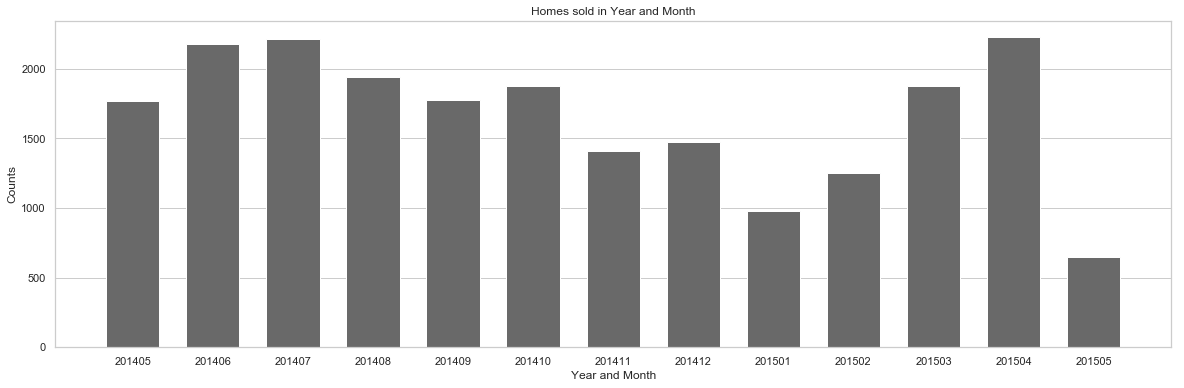

In [10]:
counts = data["sale_month"].value_counts().sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, counts, width, color="dimgray", align="center")
axes.set_xticks(x)
axes.set_xticklabels(counts.axes[0])
axes.set_title( "Homes sold in Year and Month")
axes.set_xlabel("Year and Month")
axes.set_ylabel( "Counts")
axes.xaxis.grid(False)

plt.show()
plt.close()

Although the January 2015 dip is interesting, when charted, it doesn't appear as pronounced as it did in the data. Sales recover in February and are even better in March and April. There may be some seasonality here but we'd need to see more data to be sure.

The dip in sales in May 2015, however, is just staggering. We may want to find out more information to corroborate this (look for newspaper articles, etc.). It's not clear, though, that this means the price of homes, our goal, was effected.

### price

`price` is our target variable and therefore the chief variable of interest. 

(Pandas has tendency to display very large numbers in scientific notation which can be annoying. We can fix that:

In [11]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Let's first get a sense of the price range of houses in King County:

In [12]:
data["price"].describe()

count     21613.00
mean     540088.14
std      367127.20
min       75000.00
25%      321950.00
50%      450000.00
75%      645000.00
max     7700000.00
Name: price, dtype: float64

Of the houses in the data set, the least expensive house sold for \$75,000 and the most expensive house sold for \$7,700,000. 50% of the houses sold for less than \$450,000 (and 50% for more) so we can expect the mean to be very skewed (the mean is $540,088 and is definitely pulled up).

Let's plot the data:

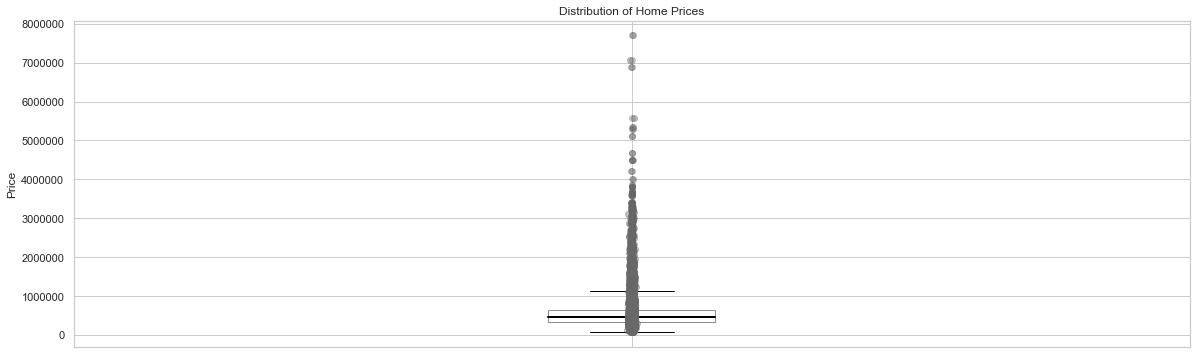

In [13]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(data[ "price"], labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of Home Prices")
axes.set_ylabel("Price")
x = np.random.normal(1, 0.001, size=len(data["price"]))
axes.plot(x, data["price"], 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

Note that a single box plot doesn't really need an x-axis label, just a title and y-axis label.

The distribution is skewed, so much so that we can't really see anything interesting. This shape is actually very common and we'll see in the next chapter what kinds of processes give rise to data like this. One approach to dealing this data is to convert it from a linear scale to a logarithmic scale. Instead of 1, 2, 3 being dollars, 1, 2, 3 will represent orders of magnitude. We can try different kinds of orders of magnitude: 10's (`np.log10`), 2's (`np.log2`), or even a natural log (base e, `np.log`).

Let's try that transformation and plot it. We'll forgo the plotting of data points since there are so many of them.

In [14]:
data["log_price"] = data[ "price"].apply(lambda x: np.log10(x))

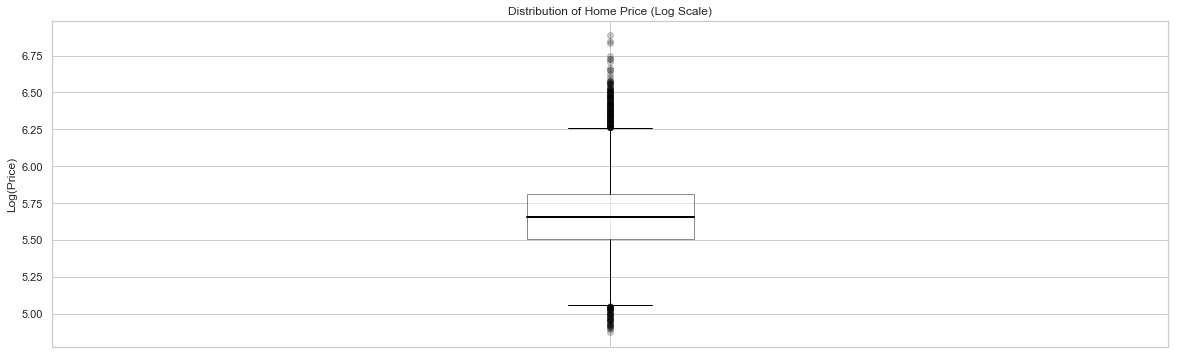

In [15]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(data[ "log_price"], labels=[""], \
                     showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of Home Price (Log Scale)")
axes.set_ylabel("Log(Price)")

plt.show()
plt.close()

With "showflier" set to true, we see that there are a lot of them both at the low range and the high range. Perhaps a histogram is better for this data:

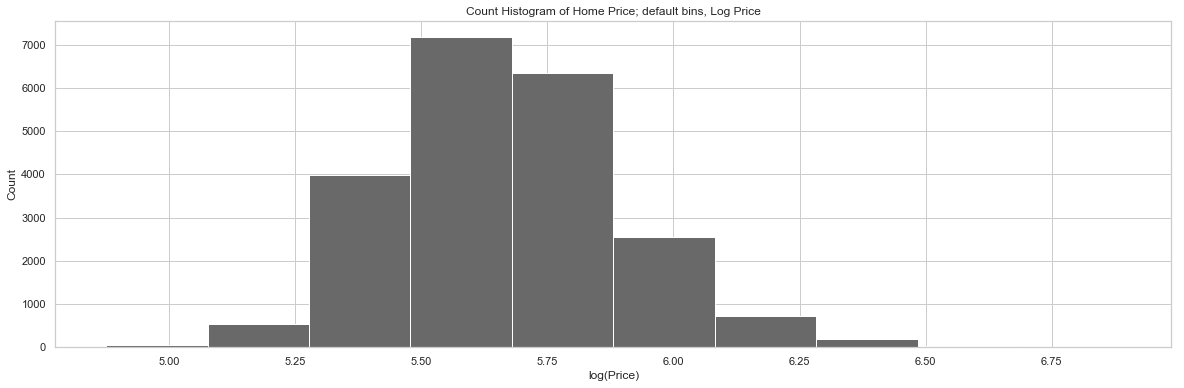

In [16]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(data[ "log_price"], color="DimGray")
axes.set_xlabel( "log(Price)")
axes.set_ylabel( "Count")
axes.set_title("Count Histogram of Home Price; default bins, Log Price")

plt.show()
plt.close()

It is often the case that data that is heavily skewed is distributed *log-normal*. Still, it's often hard to make sense of what's going on in terms of logs.

### bedrooms

`bedrooms` is a numerical variable and, along with `bathrooms`, a key feature of the typical house. In our model, the price of a house increases with the number of bedrooms. Because it is numerical we can calculate the typical descriptive statistics:

In [17]:
data["bedrooms"].describe()

count   21613.00
mean        3.37
std         0.93
min         0.00
25%         3.00
50%         3.00
75%         4.00
max        33.00
Name: bedrooms, dtype: float64

Looking at the extreme values first, we see that the lowest number of bedrooms is 0 which doesn't necessarily make sense. It's possible that the data contains some non-residential properties and if we had the chance, we should probably look into it. The highest number of bedrooms is 33.

The mean is 3.37 and the median is 3.0. However, most houses (75%) have 4 or fewer bedrooms. We might get more out of this data by treating it as categorical. This is sometimes the case with count variables with only a few possibilities:

In [18]:
data["bedrooms"].value_counts().sort_index()

0       13
1      199
2     2760
3     9824
4     6882
5     1601
6      272
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

There is only one house with 33 bedrooms and only 1 house with 11 bedrooms. Let's plot the data using a bar chart. There's very rarely a reason to *show* both a chart for counts and a chart for percentages. In this case, we have the raw counts above if we need to refer to them so we'll just show the percentages.

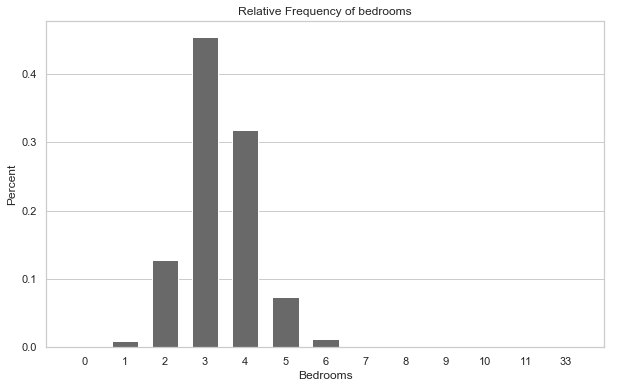

In [19]:
counts = data["bedrooms"].value_counts().sort_index()
proportions = data["bedrooms"].value_counts(normalize=True).sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, proportions, width, color="dimgray", align="center")
axes.set_xlabel("Bedrooms")
axes.set_xticks(x)
axes.set_xticklabels(proportions.axes[0])
axes.set_title( "Relative Frequency of bedrooms")
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)

plt.show()
plt.close()

It looks the mode is 3 bedrooms. The mode is the most prevalent category or class. 

The scaling represents an interesting challenge. As categorical data there's nothing wrong with "11" and "33" being next to each other. As count data, having 11 and 33 next to each other is deceiving. On the other hand, there are no visible bars. If we were to include this chart in a report, we'd need to fix this. One solution would be to remove the 33 room house and make a footnote to the chart.

### bathrooms

`bathrooms` is also a numerical variable and a key feature of typical homes and concern of home buyers. As with bedrooms, we can treat it as a numerical variable and as a categorical variable.

Let's start by describing it:

In [20]:
data["bathrooms"].describe()

count   21613.00
mean        2.11
std         0.77
min         0.00
25%         1.75
50%         2.25
75%         2.50
max         8.00
Name: bathrooms, dtype: float64

As with `bedrooms`, the lowest number of bathrooms is 0. The highest number of bathrooms is 8. Do the 33 bedrooms and 8 bathrooms go together?

In [21]:
data[data["bathrooms"] == 8.0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sale_month,log_price
7252,6762700020,20141013T000000,7700000.00,6,8.00,12050,27600,2.50,0,3,4,13,8570,3480,1910,1987,98102,47.63,-122.32,3940,8800,201410,6.89
12777,1225069038,20140505T000000,2280000.00,7,8.00,13540,307752,3.00,0,4,3,12,9410,4130,1999,0,98053,47.67,-121.99,4850,217800,201405,6.36


Oddly enough, no, although the 6 bedroom and 8 bathroom house is the highest price house. This means the 33 bedroom house had fewer than 8 bathrooms. How many did it have?

In [22]:
data[data["bedrooms"] == 33]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sale_month,log_price
15870,2402100895,20140625T000000,640000.00,33,1.75,1620,6000,1.00,0,0,5,7,1040,580,1947,0,98103,47.69,-122.33,1330,4700,201406,5.81


33 bedrooms and 1.75 baths? That seems like a data entry problem.

While this is interesting, it is a rabbit hole. This is an example of what not to do, at least on the first pass. We should have simply noted our questions and moved on:

1. Are the highest number of bedrooms (33) and highest number of bathrooms (8), the same house?
2. If not, how many bathrooms does the house with 33 bedrooms have?

We can treat bathrooms as a categorical variable as well although there are more values because you can have half and 75% (?) baths.

In [23]:
data["bathrooms"].value_counts().sort_index()

0.00      10
0.50       4
0.75      72
1.00    3852
1.25       9
1.50    1446
1.75    3048
2.00    1930
2.25    2047
2.50    5380
2.75    1185
3.00     753
3.25     589
3.50     731
3.75     155
4.00     136
4.25      79
4.50     100
4.75      23
5.00      21
5.25      13
5.50      10
5.75       4
6.00       6
6.25       2
6.50       2
6.75       2
7.50       1
7.75       1
8.00       2
Name: bathrooms, dtype: int64

As before, we can plot these as bar charts:

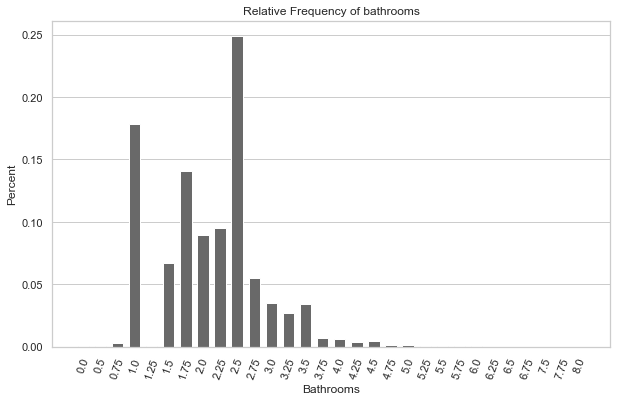

In [24]:
counts = data["bathrooms"].value_counts().sort_index()
proportions = data["bathrooms"].value_counts(normalize=True).sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, proportions, width, color="dimgray", align="center")
axes.set_xlabel("Bathrooms")
axes.set_xticks(x)
axes.set_xticklabels(proportions.axes[0])
axes.set_title( "Relative Frequency of bathrooms")
axes.set_ylabel( "Percent")
axes.xaxis.grid(False)
plt.setp( axes.xaxis.get_majorticklabels(), rotation=70)

plt.show()
plt.close()

The most common numbers of bathrooms is 1 and 2.5. 1.75 bathrooms is not far behind. We might need to look into what a "3/4 bath" is. A "1/2 bath" is more common (no tub or shower).

### sqft_living

The square footage of a house's living space is a broad measure of the house's livability. Although the chief concern is often bedrooms and bathrooms, people often like large public rooms such as kitchens, living rooms, and family rooms.

`sqft_living` is a numerical variable.

In [25]:
data["sqft_living"].describe()

count   21613.00
mean     2079.90
std       918.44
min       290.00
25%      1427.00
50%      1910.00
75%      2550.00
max     13540.00
Name: sqft_living, dtype: float64

The minimum square footage is 290. That's about 17x17 feet for *everything*. The largest square footage is 13,540. The mean is 2079 and the median is 1910 which suggest we may have another skewed distribution. It occurs to me that we can see if the 33 rooms is typo by checking to see if the square feet of living space matches. If the rooms end up being 10 feet square each, that's probably wrong.

1. Check square footage of living space for the 33 room house.


We can use a box plot to see the data:

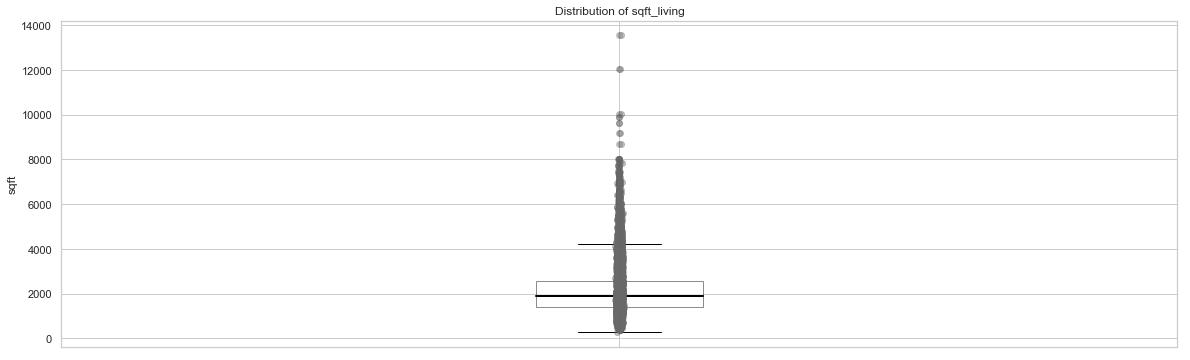

In [26]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(data[ "sqft_living"], labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of sqft_living")
axes.set_ylabel("sqft")
x = np.random.normal(1, 0.001, size=len(data["sqft_living"]))
axes.plot(x, data["sqft_living"], 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

Square feet of living space is also quite skewed. We could take the log of it as we did with prices:

In [27]:
data["log_sqft_living"] = data[ "sqft_living"].apply(lambda x: np.log10(x))

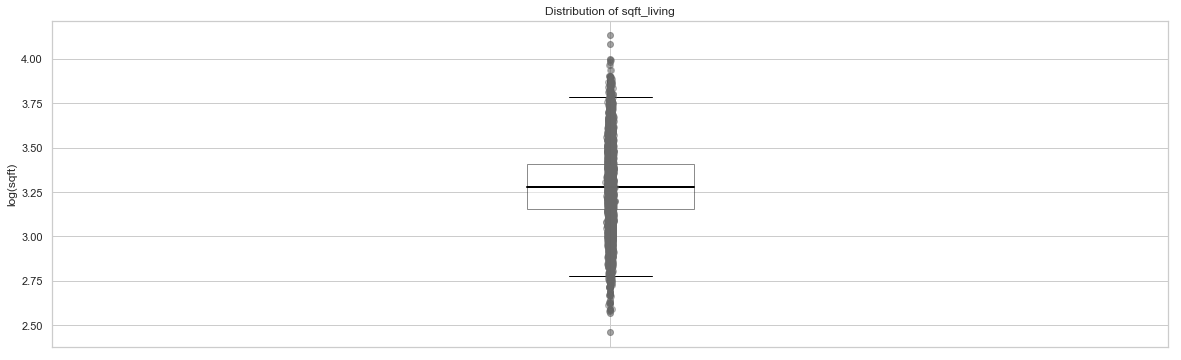

In [28]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(data[ "log_sqft_living"], labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of sqft_living")
axes.set_ylabel("log(sqft)")
x = np.random.normal(1, 0.001, size=len(data["log_sqft_living"]))
axes.plot(x, data["log_sqft_living"], 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

The distribution looks perfectly symmetrical. Let's check with a histogram:

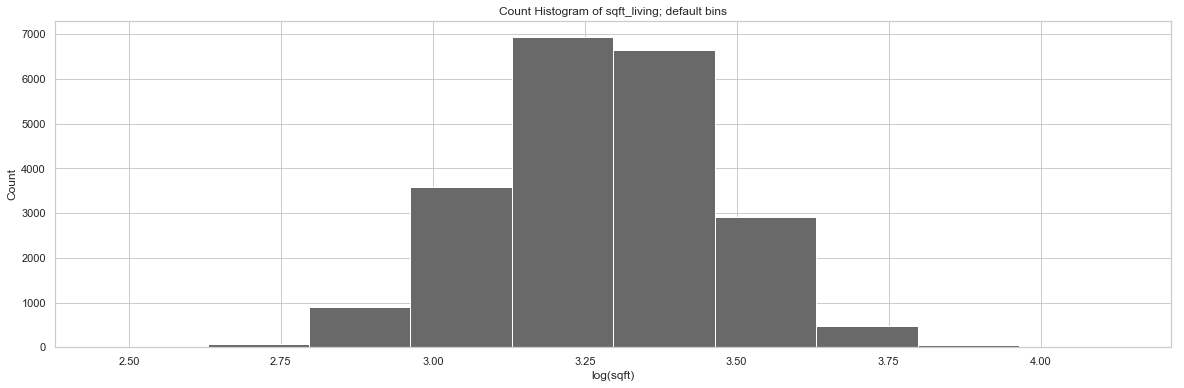

In [29]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(data[ "log_sqft_living"], color="DimGray")
axes.set_xlabel( "log(sqft)")
axes.set_ylabel( "Count")
axes.set_title("Count Histogram of sqft_living; default bins")

plt.show()
plt.close()

We could have taken a different approach. The name contains a clue: "square feet". What happens if we take the square root of the square footage and get just "footage"?

In [30]:
data["ft_living"] = data[ "sqft_living"].apply(lambda x: np.sqrt(x))

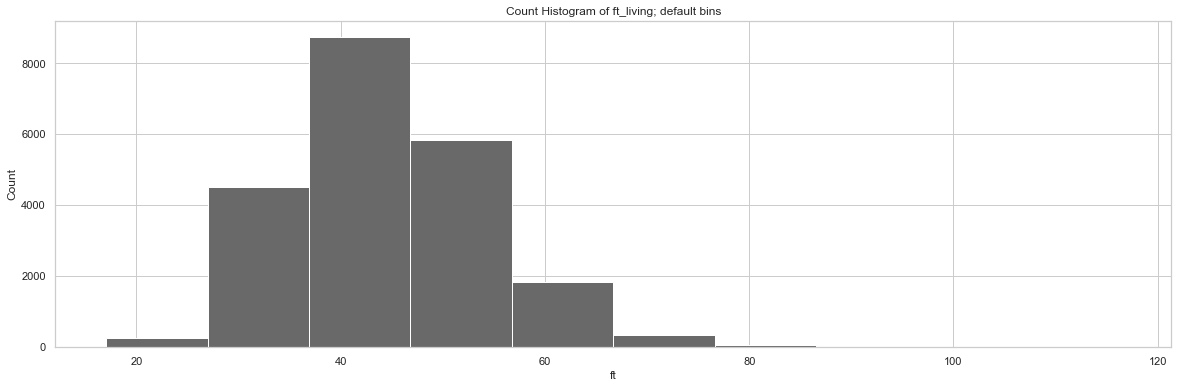

In [31]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(data[ "ft_living"], color="DimGray")
axes.set_xlabel( "ft")
axes.set_ylabel( "Count")
axes.set_title("Count Histogram of ft_living; default bins")

plt.show()
plt.close()

It's not quite as "normal" but it does have the advantage of being in units we can readily interpret...maybe. Feet of living space? Sometimes it works; sometimes it doesn't.

Many times you will have variables that are related. In our case, we have `sqft_living`, `sqft_basement`, `sqft_lot`, etc. We have every reason so suspect that we'll need to do the same thing we just did for `sqft_living`. There's no reason to "rediscover" it again; just do it. We're also repeating a lot of code. At this point, we might just put our chart into a function. (However, don't put more than one chart per function. You should only output "one" chart--counts and proportions are one chart--per code cell).

Note that I just paused here to re-run the kernel. You should do this regularly to make sure that you haven't gotten something accidentally out of the proper execution order.

### sqft_lot

The size of the lot, `sqft_lot`, is the total square feet of the property. There are 43,560 square feet in an acre.

In [32]:
data["sqft_lot"].describe()

count     21613.00
mean      15106.97
std       41420.51
min         520.00
25%        5040.00
50%        7618.00
75%       10688.00
max     1651359.00
Name: sqft_lot, dtype: float64

The smallest lot is 520 square feet. It would be interesting to compare square feet of living space to the square feet of there corresponding lot.

The largest lot is 1,651,359 square feet. That's 37.91 acres. We can perform a log transformation on sqft_lot as well:

In [33]:
data["log_sqft_lot"] = data[ "sqft_lot"].apply(lambda x: np.log10(x))

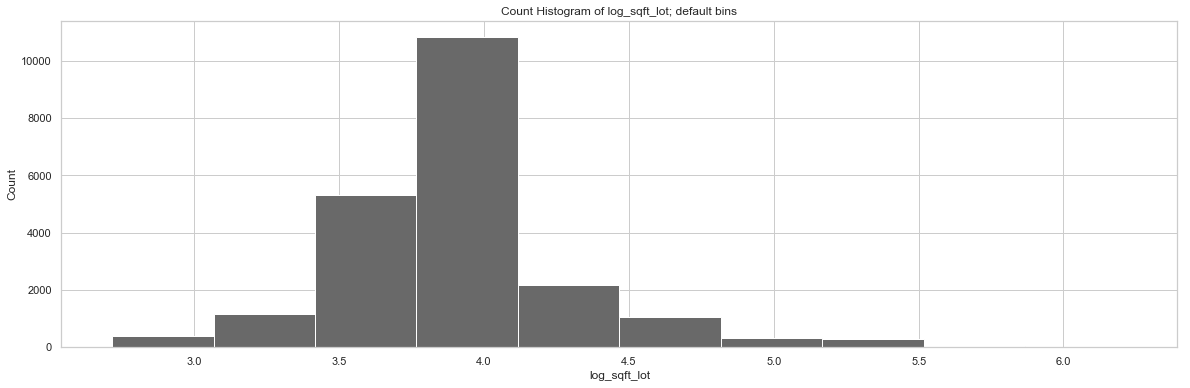

In [34]:
feature = "log_sqft_lot"

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(data[feature], color="DimGray")
axes.set_xlabel("log_sqft_lot")
axes.set_ylabel("Count")
axes.set_title("Count Histogram of " + feature + "; default bins")

plt.show()
plt.close()

Even with the log transformation, this is still a bit skewed.

### floors

Floors is another variable that we can treat as both a numerical and categorical variable. First, let's `describe` the variable:

In [35]:
data["floors"].describe()

count   21613.00
mean        1.49
std         0.54
min         1.00
25%         1.00
50%         1.50
75%         2.00
max         3.50
Name: floors, dtype: float64

Fortunately, the lowest number of floors is 1. The highest number of floors is 3.5. Finished attics that you can't stand up in all the way are often counted as half a floor.

In [36]:
data["floors"].value_counts().sort_index()

1.00    10680
1.50     1910
2.00     8241
2.50      161
3.00      613
3.50        8
Name: floors, dtype: int64

We can chart this distribution but first let's create a function that does it:

In [37]:
def bar_charts(data, feature):
    counts = data[feature].value_counts().sort_index()
    proportions = data[feature].value_counts(normalize=True).sort_index()
    x = range( len( counts))
    width = 1/1.5

    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)
    axes.set_xlabel(feature)
    axes.bar(x, proportions, width, color="dimgray", align="center")
    axes.set_xticks(x)
    axes.set_xticklabels(proportions.axes[0])
    axes.set_title( "Relative Frequency of " + feature)
    axes.set_ylabel( "Percent")
    axes.xaxis.grid(False)

    plt.show()
    plt.close()

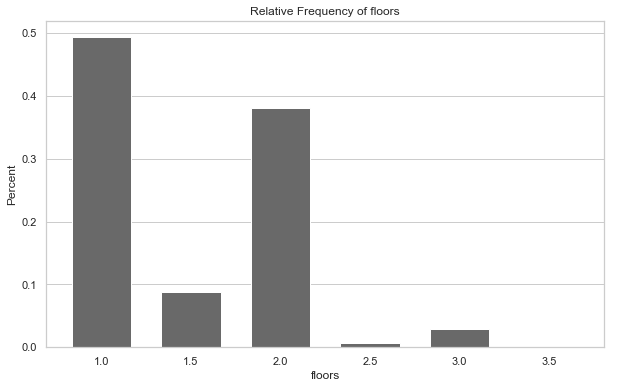

In [38]:
bar_charts(data, "floors")

Nearly 50% of all the houses that sold were single story although quite a few two story homes were sold as well (around 37%).

### waterfront

`waterfront` is a categorical variable. More specifically, it is a *binary* variable that takes the values "false" (0) and "true" (1). We can get a distribution of its values using `value_counts()`:

In [39]:
data["waterfront"].value_counts().sort_index()

0    21450
1      163
Name: waterfront, dtype: int64

The interesting thing here is that we can treat it is a numerical variable and get the average value:

In [40]:
data["waterfront"].mean()

0.007541757275713691

which ends up being the proportion for which the value is true. In this case, it means that 0.7% of the houses that sold were waterfront properties.

Even if `waterfront` is an important feature, we may not have enough observations (163) to build a good model for the price of waterfront properties.

### view

View is a categorical variable and it's not clear what it means.

In [41]:
data["view"].value_counts().sort_index()

0    19489
1      332
2      963
3      510
4      319
Name: view, dtype: int64

If we look at the proportions:

In [42]:
data["view"].value_counts( normalize=True).sort_index()

0   0.90
1   0.02
2   0.04
3   0.02
4   0.01
Name: view, dtype: float64

90% percent of the houses that sold did not have a "view". Again, we may not have enough data to build a good model for view. For example, consider all the houses in very nice neighborhood. They may all have views as well as many bedrooms and bathrooms. View may not be a differentiator for those houses and if you compare a single house elsewhere to them with the same number of bedrooms and bathrooms, the neighborhood alone might be the differentiator.

Still, if we're going to use this variable, we should find out what it means.

### condition

`condition` represents the overall condition of the house. We don't have a data dictionary that explains what each one means.

In [43]:
data["condition"].value_counts().sort_index()

1       30
2      172
3    14031
4     5679
5     1701
Name: condition, dtype: int64

If we look at the normalized counts:

In [44]:
data["condition"].value_counts( normalize=True).sort_index()

1   0.00
2   0.01
3   0.65
4   0.26
5   0.08
Name: condition, dtype: float64

Taking both of these together, we note that only 30 houses have the lowest condition (or what we presume is the lowest condition) while 8% have the highest condition. Most (65%) have a condition of 3, in the middle.

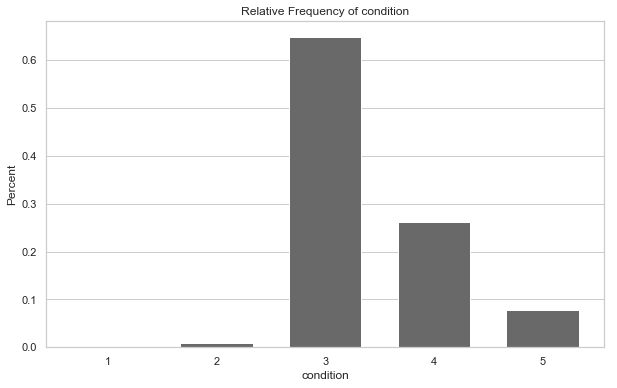

In [45]:
bar_charts(data, "condition")

(A chart can show visually what comparing "14031" and "5679" mentally may not)

### grade

The `grade` refers to an official King County grading system but an explanation of the grading system is not included.

In [46]:
data["grade"].value_counts().sort_index()

1        1
3        3
4       29
5      242
6     2038
7     8981
8     6068
9     2615
10    1134
11     399
12      90
13      13
Name: grade, dtype: int64

Only 1 house has the lowest grade and 13 houses have the highest grade. The overall distribution appears fairly "normal" which is itself interesting. The `condition` score was not symmetric.

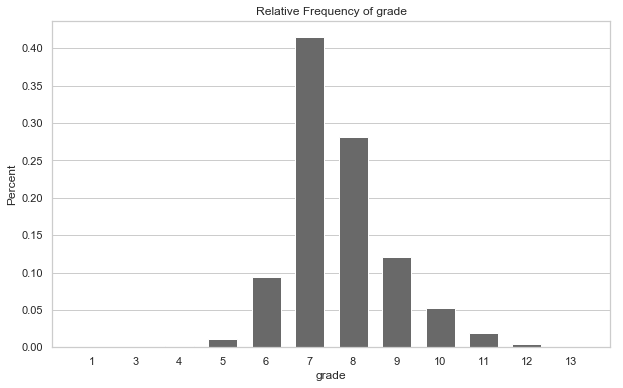

In [47]:
bar_charts(data, "grade")

More than 40% of the houses have a score of 7. A bit more than 75% of the houses have a score of 7-9.

### sqft_above

Both `sqft_above` and the next variable, `sqft_basement`, are related to `sqft_living`. They are, respectively, the living space "above" the basement and the living space that is the basement.

In [48]:
data["sqft_above"].describe()

count   21613.00
mean     1788.39
std       828.09
min       290.00
25%      1190.00
50%      1560.00
75%      2210.00
max      9410.00
Name: sqft_above, dtype: float64

We should probably compare this to the `sqft_living` but it appears that the minimum "above" and the minimum of *total* living space are both 290 square feet.

In [49]:
data["log_sqft_above"] = data[ "sqft_above"].apply(lambda x: np.log10(x))

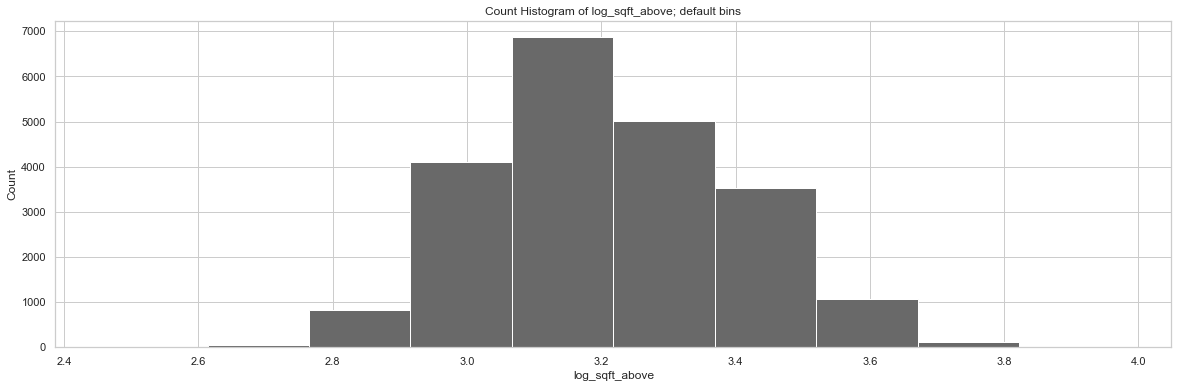

In [50]:
feature = "log_sqft_above"

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.hist(data[feature], color="DimGray")
axes.set_xlabel(feature)
axes.set_ylabel("Count")
axes.set_title("Count Histogram of " + feature + "; default bins")

plt.show()
plt.close()

The interesting question here is if we can use either of these two variables to estimate the *yard* size.

### sqft_basement

This is the other part of the living space square footage.

In [51]:
data["sqft_basement"].describe()

count   21613.00
mean      291.51
std       442.58
min         0.00
25%         0.00
50%         0.00
75%       560.00
max      4820.00
Name: sqft_basement, dtype: float64

The minimum is 0 as is the Q1 and median. This suggests *most* houses don't have basements. Note that we can't take the log of 0.

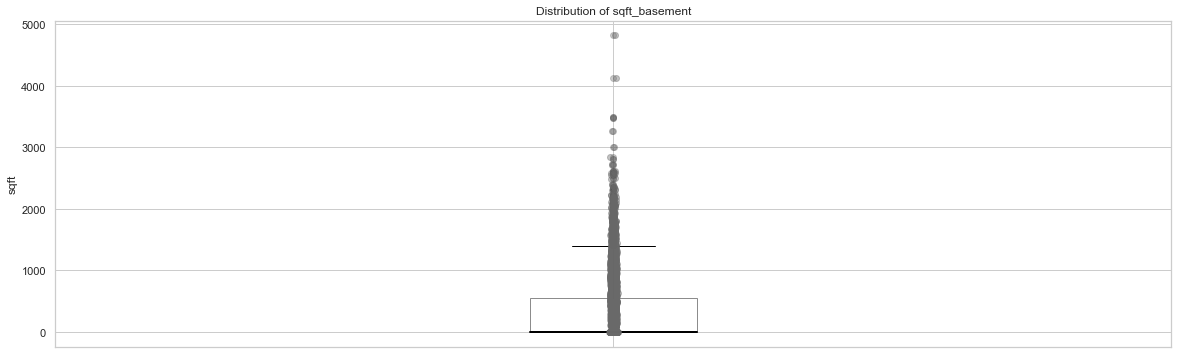

In [52]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(data[ "sqft_basement"], labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of sqft_basement")
axes.set_ylabel("sqft")
x = np.random.normal(1, 0.001, size=len(data["sqft_basement"]))
axes.plot(x, data["sqft_basement"], 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

### yr_built

`yr_built` is a (ordered) categorical variable. We can look at the distribution of houses by year built:

In [53]:
data["yr_built"].value_counts().sort_index()

1900     87
1901     29
1902     27
1903     46
1904     45
1905     74
1906     92
1907     65
1908     86
1909     94
1910    134
1911     73
1912     79
1913     59
1914     54
1915     64
1916     79
1917     56
1918    120
1919     88
1920     98
1921     76
1922     95
1923     84
1924    139
1925    165
1926    180
1927    115
1928    126
1929    114
1930     90
1931     61
1932     38
1933     30
1934     21
1935     24
1936     40
1937     68
1938     52
1939    106
1940    156
1941    161
1942    223
1943    170
1944    140
1945     95
1946    126
1947    263
1948    235
1949    195
1950    250
1951    229
1952    220
1953    223
1954    305
1955    271
1956    198
1957    198
1958    224
1959    334
1960    248
1961    224
1962    312
1963    256
1964    172
1965    187
1966    250
1967    350
1968    381
1969    280
1970    132
1971    104
1972    149
1973    149
1974    162
1975    189
1976    253
1977    417
1978    387
1979    343
1980    240
1981    199
1982    105
1983

In [54]:
data["yr_built"].describe()

count   21613.00
mean     1971.01
std        29.37
min      1900.00
25%      1951.00
50%      1975.00
75%      1997.00
max      2015.00
Name: yr_built, dtype: float64

Because it's possible to come up with a mean year in which no house was built, we're probably safest referring to the non-parametric statistics which will refer to actual data.

The earliest house was built in 1900 and the most recent house is 2015. The median house was built in 1975.

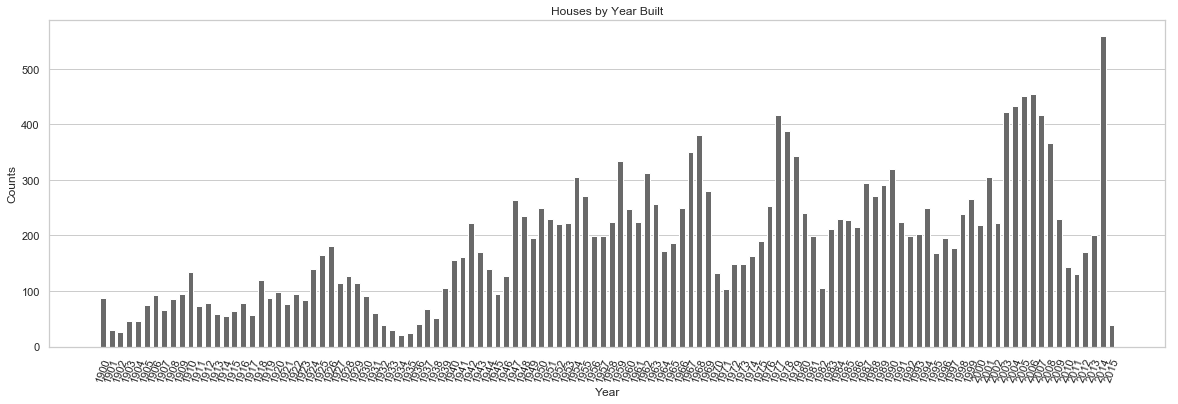

In [55]:
counts = data["yr_built"].value_counts().sort_index()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, counts, width, color="dimgray", align="center")
axes.set_xticks(x)
axes.set_xticklabels(counts.axes[0])
axes.set_title( "Houses by Year Built")
axes.set_xlabel("Year")
axes.set_ylabel( "Counts")
axes.xaxis.grid(False)
plt.setp( axes.xaxis.get_majorticklabels(), rotation=70)

plt.show()
plt.close()

At this point, 116 observations is probably continuous enough for this to be a line chart:

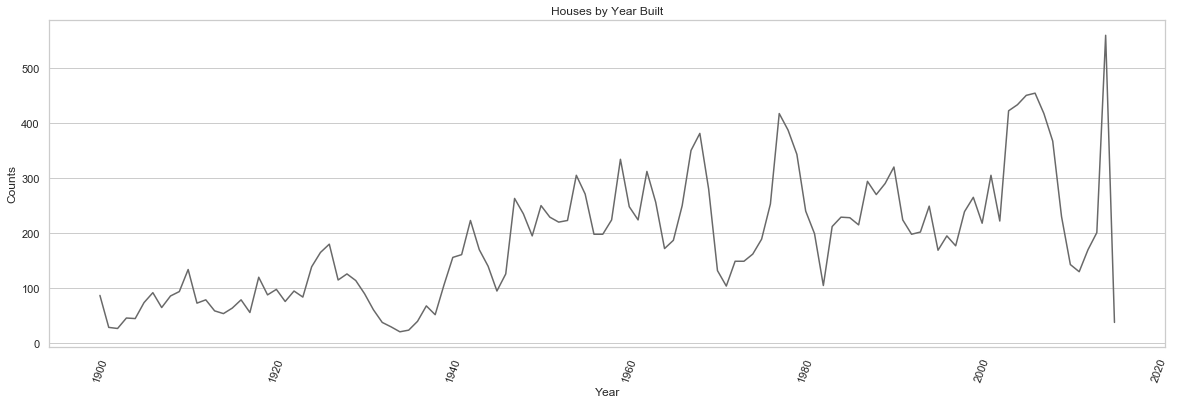

In [56]:
counts = data["yr_built"].value_counts().sort_index()
x = counts.index
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.plot(x, counts, color="dimgray")
#axes.set_xticks(x)
#axes.set_xticklabels(counts.axes[0])
axes.set_title( "Houses by Year Built")
axes.set_xlabel("Year")
axes.set_ylabel( "Counts")
axes.xaxis.grid(False)
plt.setp( axes.xaxis.get_majorticklabels(), rotation=70)

plt.show()
plt.close()

Perhaps the most interesting thing we can see in this data is the long term economic life of Seattle, both the booms and busts. The Great Depression is there (1930's) as well as the OPEC Oil shock (Mid 70s), the 1982-84 "Double Dip" Recession, as well as the 2007 Great Recession.

### yr_renovated

This is an interesting variable. What does it mean in 2018 to have a house built in 1916 that was last renovated in 1934? Additionally, most of the houses have not been renovated.

In [57]:
data["yr_renovated"].value_counts().sort_index()

0       20699
1934        1
1940        2
1944        1
1945        3
1946        2
1948        1
1950        2
1951        1
1953        3
1954        1
1955        3
1956        3
1957        3
1958        5
1959        1
1960        4
1962        2
1963        4
1964        5
1965        5
1967        2
1968        8
1969        4
1970        9
1971        2
1972        4
1973        5
1974        3
1975        6
1976        3
1977        8
1978        6
1979       10
1980       11
1981        5
1982       11
1983       18
1984       18
1985       17
1986       17
1987       18
1988       15
1989       22
1990       25
1991       20
1992       17
1993       19
1994       19
1995       16
1996       15
1997       15
1998       19
1999       17
2000       35
2001       19
2002       22
2003       36
2004       26
2005       35
2006       24
2007       35
2008       18
2009       22
2010       18
2011       13
2012       11
2013       37
2014       91
2015       16
Name: yr_renovated, 

Although we can treat `yr_renovated` as we did with `yr_built`, `describe` isn't going to tell us much because the largest proportion of houses weren't renovated.

In [58]:
data["yr_renovated"].describe()

count   21613.00
mean       84.40
std       401.68
min         0.00
25%         0.00
50%         0.00
75%         0.00
max      2015.00
Name: yr_renovated, dtype: float64

Additionally, some have been renovated so long ago that it's not clear it counts as renovation. Home buyers want to see updated kitchens and bathrooms.

What we can do is plot only the houses that were renovated:

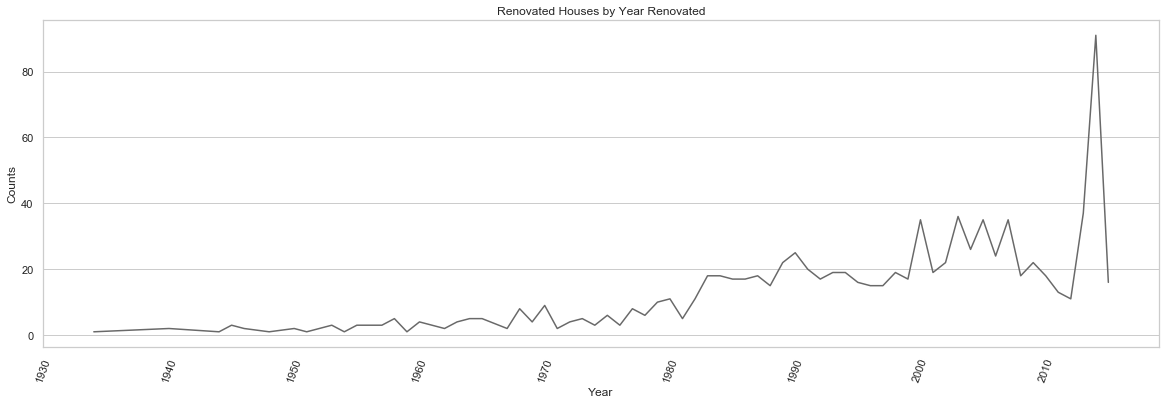

In [59]:
counts = data[data["yr_renovated"] > 0]["yr_renovated"].value_counts().sort_index()
x = counts.index
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.plot(x, counts, color="dimgray")
axes.set_title( "Renovated Houses by Year Renovated")
axes.set_xlabel("Year")
axes.set_ylabel( "Counts")
axes.xaxis.grid(False)
plt.setp( axes.xaxis.get_majorticklabels(), rotation=70)

plt.show()
plt.close()

Most of the renovations for renovated houses were done in the last few years. This make sense because people will often renovate before selling in order to get a better sales price.

Still, the number of such houses are such that we might not be able to build a model that can use so few instances of it.

### zipcode

Zip codes are an important proxy for neighborhood, especially in a heavily populated area where there are many zip codes. In contrast, where I live, there is only one zip code for almost the whole county.

Zip codes are categorical variables. Our main interest here will be the proportions of houses in each zip code. It's possible that some zip codes will be more commercial and only a few residential listings.

In [60]:
data["zipcode"].value_counts().sort_index()

98001    362
98002    199
98003    280
98004    317
98005    168
98006    498
98007    141
98008    283
98010    100
98011    195
98014    124
98019    190
98022    234
98023    499
98024     81
98027    412
98028    283
98029    321
98030    256
98031    274
98032    125
98033    432
98034    545
98038    590
98039     50
98040    282
98042    548
98045    221
98052    574
98053    405
98055    268
98056    406
98058    455
98059    468
98065    310
98070    118
98072    273
98074    441
98075    359
98077    198
98092    351
98102    105
98103    602
98105    229
98106    335
98107    266
98108    186
98109    109
98112    269
98115    583
98116    330
98117    553
98118    508
98119    184
98122    290
98125    410
98126    354
98133    494
98136    263
98144    343
98146    288
98148     57
98155    446
98166    254
98168    269
98177    255
98178    262
98188    136
98198    280
98199    317
Name: zipcode, dtype: int64

We'll also want to sort the counts.

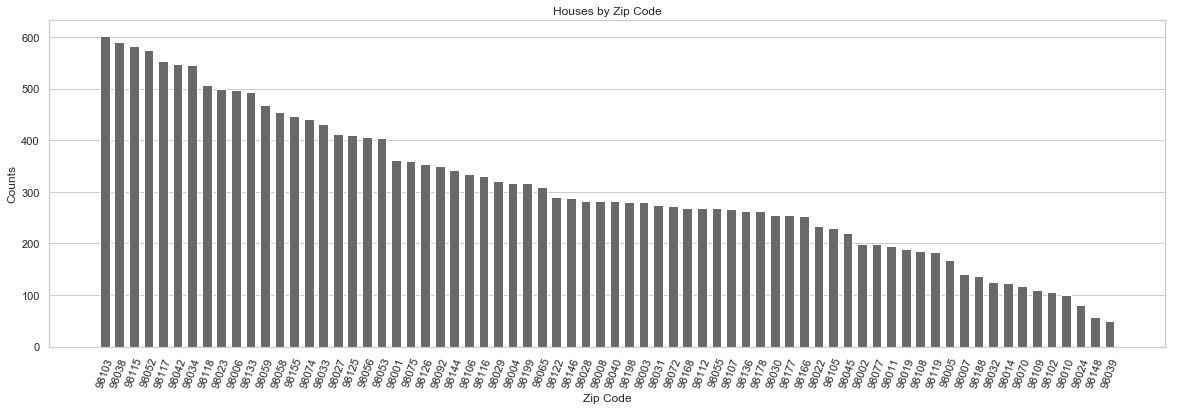

In [61]:
counts = data["zipcode"].value_counts()
x = range( len( counts))
width = 1/1.5

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.bar(x, counts, width, color="dimgray", align="center")
axes.set_xticks(x)
axes.set_xticklabels(counts.axes[0])
axes.set_title( "Houses by Zip Code")
axes.set_xlabel("Zip Code")
axes.set_ylabel( "Counts")
axes.xaxis.grid(False)
plt.setp( axes.xaxis.get_majorticklabels(), rotation=70)

plt.show()
plt.close()

This chart shows us that some zip codes had fewer than 100 home sales. This means any model we build or analysis we do may not apply as strongly to those zip codes.

### lat and long

I'm ignoring lat and long for now as they're fairly abstract. We could use them later for analytics. Although it's not automatically true, it is possible that plotting some of the data on a map would be helpful.

### sqft_living15

`sqft_living15` measures the square footage of living space in 2015. We might be able to compare this variable to `sqft_living` to determine the extent of renovations. We haven't talked about *derived* variables yet.

For now, we know that it will probably follow the same pattern as `sqft_living`:

In [62]:
data["sqft_living15"].describe()

count   21613.00
mean     1986.55
std       685.39
min       399.00
25%      1490.00
50%      1840.00
75%      2360.00
max      6210.00
Name: sqft_living15, dtype: float64

In [63]:
data["log_sqft_living15"] = data[ "sqft_living"].apply(lambda x: np.log10(x))

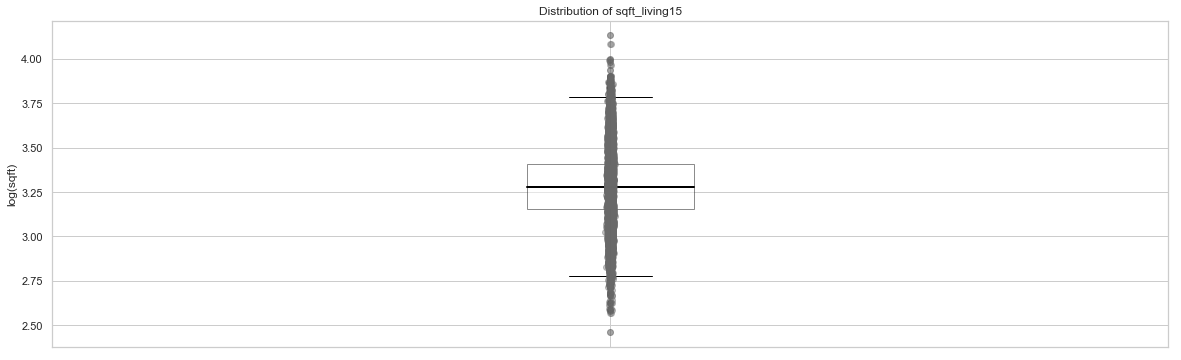

In [64]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(data[ "log_sqft_living15"], labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of sqft_living15")
axes.set_ylabel("log(sqft)")
x = np.random.normal(1, 0.001, size=len(data["log_sqft_living15"]))
axes.plot(x, data["log_sqft_living15"], 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

### sqft_lot15

It's not entirely clear how the lot size can increase except by adding land from adjoining parcels.

In [65]:
data["sqft_lot15"].describe()

count    21613.00
mean     12768.46
std      27304.18
min        651.00
25%       5100.00
50%       7620.00
75%      10083.00
max     871200.00
Name: sqft_lot15, dtype: float64

In [66]:
data["log_sqft_lot15"] = data[ "sqft_lot15"].apply(lambda x: np.log10(x))

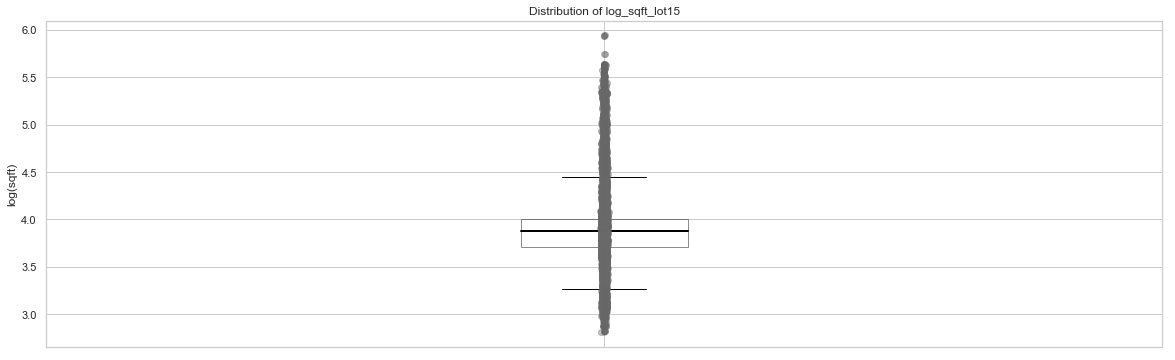

In [67]:
figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
patch = axes.boxplot(data[ "log_sqft_lot15"], labels=[''], showfliers=True, patch_artist=True, zorder=1)
eda.restyle_boxplot( patch)
axes.set_title("Distribution of log_sqft_lot15")
axes.set_ylabel("log(sqft)")
x = np.random.normal(1, 0.001, size=len(data["log_sqft_lot15"]))
axes.plot(x, data["log_sqft_lot15"], 'o', alpha=0.4, color="DimGray", zorder=2)

plt.show()
plt.close()

You don't have to dwell too much on the Single Variable EDA. Find the basic patterns and look for "weirdness". Make a note of everything you find. If you like, you can end the Single Variable EDA with a summary of all the open questions and concerns.

You then proceed into the Pairwise EDA guided by your question or problem (or, in the worse case, a correlation matrix and domain knowledge). The pairwise EDA is much more interesting.

## Pairwise EDA

Because we have a research question, what determines the price of houses that sold in King County, Washington, in 2014-2015, we have a guide for conducting pairwise EDA. We'll look at every variable in relation to price. Along the way, additional questions may suggest themselves. Just make a note of them.

As before, you can pre-fill your notebook with three cells per variable. Additionally, the comparisons are going to be Numerical v. Numerical or Numerical v. Categorical. We also know that we need to work in $log_{10}$ for many of our variables including `price` and all the square foot measures.

We needn't necessarily look at every pairwise comparison. For example, does it make sense to compare `date` and `price`? If we are predicting something, we won't have a date. Still, it may be interesting to compare `date` and `price` to see if prices were stable over the range of dates.

For numerical v. numerical comparisons, we've already calculated the individual descriptive statistics above. The only reason to calculate them again is if they were particularly interesting and you don't want your reader (or you) to have to scroll back and forth. For numerical v. categorical comparisons, you are going to want to calculate individual descriptive statistics for each category.

As before, many of the variables are numerical and discrete with finite values, this allows us to treat them as both categorical and numerical, permitting us to get different views on the data.

Finally, here are some helper functions for this specific EDA problem.

`correlation` prints out $\rho$ and $r$ for two variables.

In [68]:
def correlation(data, x, y):
    print("Correlation coefficients:")
    print( "r   =", stats.pearsonr(data[x], data[y])[0])
    print( "rho =", stats.spearmanr(data[x], data[y])[0])

`describe_by_category` will show descriptive statistics for a numerical variable by each value of the categorical variable.

In [69]:
def describe_by_category(data, numeric, categorical):
    grouped = data.groupby(categorical)
    grouped_y = grouped[numeric].describe()
    print(grouped_y)

`lowess_scatter` underwent a bit of evolution that can't be seen in the final draft. First, some data gives LOWESS some fits so it was decided to replace it with a regular regression line. Then it was discovered that some of the discrete counts left artifacts as discussed in a previous section, a parameter to include jitter was then added to the function.

Although generally want to show all iterations of your charts, you don't need to show all the errors and failures. But do make a note of them. Otherwise, in 8 weeks, you have no idea why you did that.

In [70]:
def lowess_scatter(data, x, y, jitter=0.0, skip_lowess=False):

    if skip_lowess:
        fit = np.polyfit(data[x], data[y], 1)
        line_x = np.linspace(data[x].min(), data[x].max(), 10)
        line = np.poly1d(fit)
        line_y = list(map(line, line_x))
    else:
        lowess = sm.nonparametric.lowess(data[y], data[x], frac=.3)
        line_x = list(zip(*lowess))[0]
        line_y = list(zip(*lowess))[1]

    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)

    xs = data[x]
    if jitter > 0.0:
        xs = data[x] + stats.norm.rvs( 0, 0.5, data[x].size)

    axes.scatter(xs, data[y], marker="o", color="DimGray", alpha=0.5)
    axes.plot(line_x, line_y, color="DarkRed")

    title = "Plot of {0} v. {1}".format(x, y)
    if not skip_lowess:
        title += " with LOWESS"
    axes.set_title(title)
    axes.set_xlabel(x)
    axes.set_ylabel(y)

    plt.show()
    plt.close()

`multiboxplot` is the visual counterpart to the `describe_by_category` function. It'll plot a numerical variable, creating a box for each category of the categorical variable.

In [71]:
def multiboxplot(data, numeric, categorical, skip_data_points=True):
    figure = plt.figure(figsize=(10, 6))

    axes = figure.add_subplot(1, 1, 1)

    grouped = data.groupby(categorical)
    labels = pd.unique(data[categorical].values)
    labels.sort()
    grouped_data = [grouped[numeric].get_group( k) for k in labels]
    patch = axes.boxplot( grouped_data, labels=labels, patch_artist=True, zorder=1)
    eda.restyle_boxplot( patch)

    if not skip_data_points:
        for i, k in enumerate(labels):
            subdata = grouped[numeric].get_group( k)
            x = np.random.normal(i + 1, 0.01, size=len(subdata))
            axes.plot(x, subdata, 'o', alpha=0.4, color="DimGray", zorder=2)

    axes.set_xlabel(categorical)
    axes.set_ylabel(numeric)
    axes.set_title("Distribution of {0} by {1}".format(numeric, categorical))

    plt.show()
    plt.close()

### date and price

We're focused on the question or problem at this point. We won't have `date` to predict the price so there's no real point in seeing if it is predictive. However, the data might have some interesting relationships between dates of sale and sale prices so it could be worth looping back and looking at this relationship.

### bedrooms and price

It seems like there should be a strong relationship between the number of bedrooms and the price.

In [72]:
correlation(data, "bedrooms", "price")

Correlation coefficients:
r   = 0.3083495981456383
rho = 0.34465237095978885


Surprisingly, the relationship between price and bedrooms is not very strong. It's certainly lower than the 50% threshold for $r$ and $\rho$ is not much larger than $r$. It's possible that number of bedrooms is a thresholding value for deciding on a particular house but it doesn't, by itself, play a role in the determination of the price.

We can look at the mean price by number of bedrooms to get a sense for this relationship. If there was a strong positive correlation between price and bedrooms, the means would be steadily increasing.

In [73]:
describe_by_category(data, "price", "bedrooms")

           count       mean       std       min       25%       50%        75%        max
bedrooms                                                                                 
0          13.00  409503.85 358682.63 139950.00 235000.00 288000.00  355000.00 1295650.00
1         199.00  317642.88 148864.96  75000.00 222000.00 299000.00  390000.00 1247000.00
2        2760.00  401372.68 198051.83  78000.00 269837.50 374000.00  490000.00 3278000.00
3        9824.00  466232.08 262469.77  82000.00 295487.50 413000.00  560000.00 3800000.00
4        6882.00  635419.50 388594.44 100000.00 376962.50 549997.50  765000.00 4489000.00
5        1601.00  786599.83 596204.00 133000.00 438000.00 620000.00  913888.00 7062500.00
6         272.00  825520.64 799238.82 175000.00 435000.00 650000.00  896250.00 7700000.00
7          38.00  951184.66 739953.56 280000.00 539250.00 728580.00  946500.00 3200000.00
8          13.00 1105076.92 897495.73 340000.00 490000.00 700000.00 1650000.00 3300000.00
9         

Although the mean price per number of bedrooms does increase over some ranges of counts of bedrooms, it doesn't increase uniformly over the entire range of counts of bedrooms.

Let's look at a box plot:

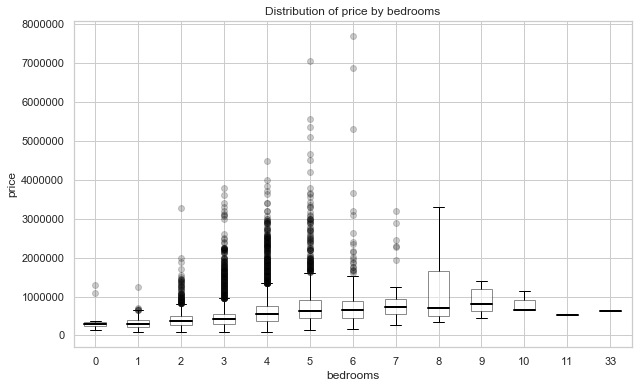

In [74]:
multiboxplot(data, "price", "bedrooms")

Because price has such a skewed distribution, it's difficult to see any thing interesting here. We can plot against log(price) as we did before but we need to take care when interpreting the values which are now comparative magnitudes of price.

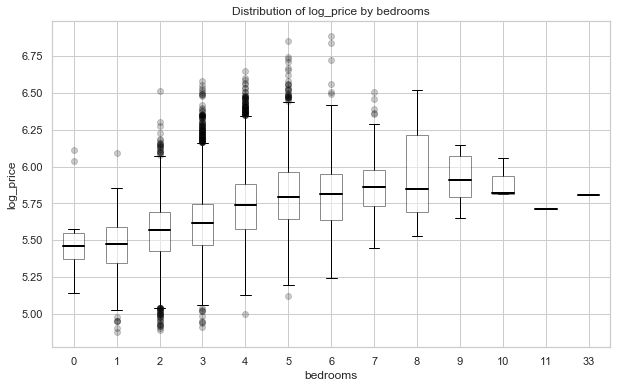

In [75]:
multiboxplot(data, "log_price", "bedrooms")

If we look at the trend for the median line of the individual boxes, there is some increase over 1-5 but not much past 5. Perhaps there are decreasing returns to the number of bedrooms?

Let's try a scatter plot:

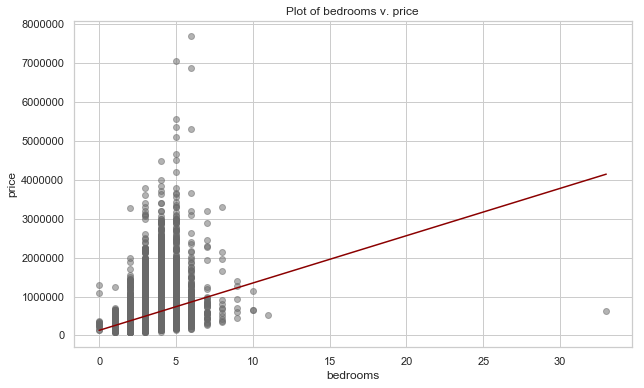

In [76]:
lowess_scatter(data, "bedrooms", "price", jitter=0.0, skip_lowess=True)

We have artifacts here because there are discrete counts of bedrooms. In order to get around this, we can add a modest amount of jitter:

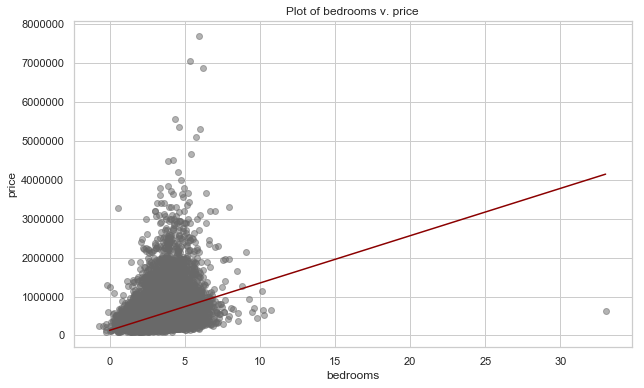

In [77]:
lowess_scatter(data, "bedrooms", "price", jitter=0.01, skip_lowess=True)

The box plot is definitely a better visual for this data but let's switch to log(price):

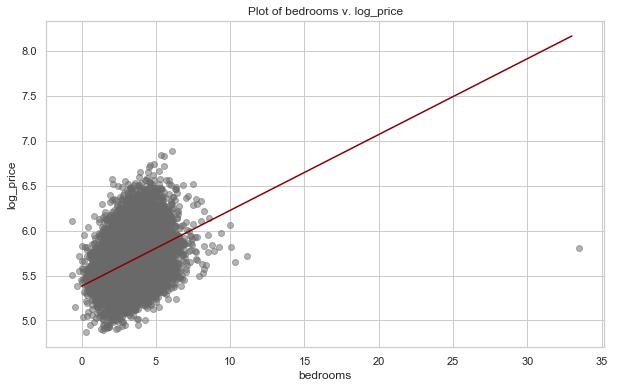

In [78]:
lowess_scatter(data, "bedrooms", "log_price", jitter=0.01, skip_lowess=True)

With 21k data points, we get a better sense of the data from the box plots. This sometimes happens. Additionally, we could have tried a hexbin plot here.

Is the position of the line surprising to you? If you look at the cloud of points, there appears to be a line of symmetry that runs approximately from (0, 5.0) to (5.0, 6.5). That imaginary line is not the regression line. This is the PCA line. The regression line is the line in red.

### bathrooms and price

As with bedrooms, bathrooms seem like a major selling point for the typical home. As with bedrooms, we think there will be a positive relationship between the number of bathrooms and the price.

In [79]:
correlation(data, "bathrooms", "price")

Correlation coefficients:
r   = 0.5251375054139619
rho = 0.49716035081092047


There appears to be a slightly stronger relationship between the number of bathrooms and price and the number of bedrooms and price. Still, $r$ only barely makes it over the "interesting" threshold.

Let's describe the relationship:

In [80]:
describe_by_category(data, "price", "bathrooms")

            count       mean        std        min        25%        50%        75%        max
bathrooms                                                                                     
0.00        10.00  448160.00  415390.19   75000.00  165250.00  317500.00  458000.00 1295650.00
0.50         4.00  237375.00   88888.86  109000.00  218500.00  264000.00  282875.00  312500.00
0.75        72.00  294520.86  138084.54   80000.00  201500.00  273500.00  355000.00  785000.00
1.00      3852.00  347041.24  154559.51   78000.00  230000.00  320000.00  425000.00 1300000.00
1.25         9.00  621216.67  407836.05  275000.00  360000.00  516500.00  545000.00 1388000.00
1.50      1446.00  409322.21  193784.69  107000.00  265962.50  370000.00  495600.00 1500000.00
1.75      3048.00  454896.10  201962.54  115000.00  310000.00  422900.00  555000.00 3278000.00
2.00      1930.00  457889.72  206005.46  115000.00  300500.00  423250.00  563000.00 2200000.00
2.25      2047.00  533676.77  280898.84  160000.00

This is really too much data to look at but again, the thought is that the mean price will steadily increase with the number of bathrooms. The descriptive statistics are fine for reference but we need a way to view the relationship. We can try box plots again but there are quite a few "categories" of bathroom counts.

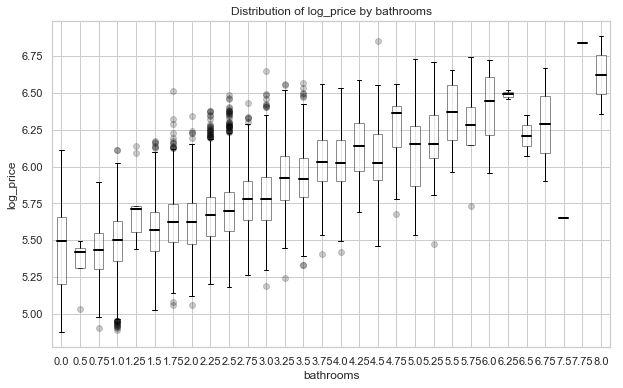

In [81]:
multiboxplot(data, "log_price", "bathrooms")

As a broad trend, the price does appear to be related to the number of bathrooms but if you look at adjacent boxes, you will very often have the same price or even a lower one.

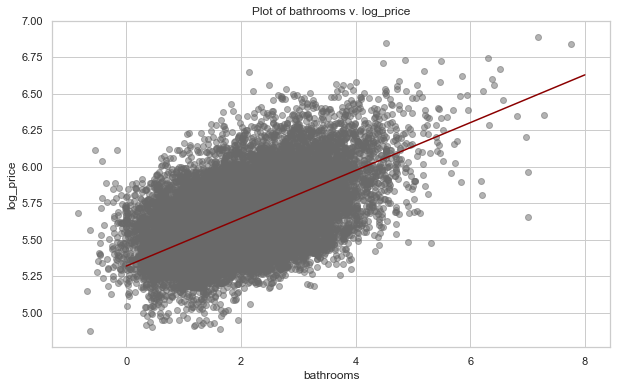

In [82]:
lowess_scatter(data, "bathrooms", "log_price", jitter=0.01, skip_lowess=True)

The box plot is quite a bit better at summarizing the relationship than the scatter plot.

### sqft_living and price

Bigger houses cost more to build and so it makes sense that a house with more square feet, other things being equal, will have a bigger price.

In [83]:
correlation(data, "sqft_living", "price")

Correlation coefficients:
r   = 0.7020350546118
rho = 0.6441909821578404


In [84]:
correlation(data, "log_sqft_living", "price")

Correlation coefficients:
r   = 0.6117036939711257
rho = 0.6441909821578404


Looking at both the relationship between the variables on both the regular and log scales, we can see that the relationship is fairly strong $r=0.70$ on the regular scale. This again suggests that bedrooms and bathrooms are how people pick houses and then the package of amenities (living room, bedrooms, kitchen) determine the price.

It would be worth looking into some of the individual relationships (between bedrooms, bathrooms and living areas). Of course, it's possible that buyers also "pre sort" themselves. They have an approval letter from their bank, a target for bathrooms and bedrooms, and then they look at houses in their price range.

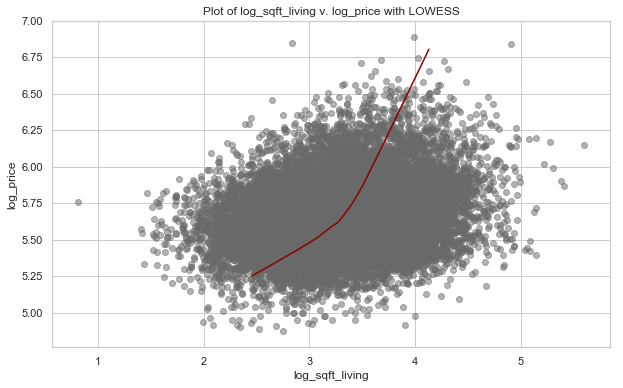

In [85]:
lowess_scatter(data, "log_sqft_living", "log_price", jitter=0.01, skip_lowess=False)

There's a very interesting bend in the LOWESS line. In log-space, non-linear relationships are linear (taking logs reduces multiplicative computations to additive ones). The bend in the line suggests maybe some kind of shift around log(sqft_living)=3.3

### sqft_lot and price

It's possible that the lot size has nothing to do with price. You can put a small house on a big lot or a large house on a small lot ("McMansions"). Still, land is not free so it might have small infuence on price.

In [86]:
correlation(data, "sqft_lot", "price")

Correlation coefficients:
r   = 0.08966086058710011
rho = 0.07493937028457391


In [87]:
correlation(data, "log_sqft_lot", "price")

Correlation coefficients:
r   = 0.1613181596161923
rho = 0.07493937028457391


It doesn't appear that lot size has much of an influence on price at all.

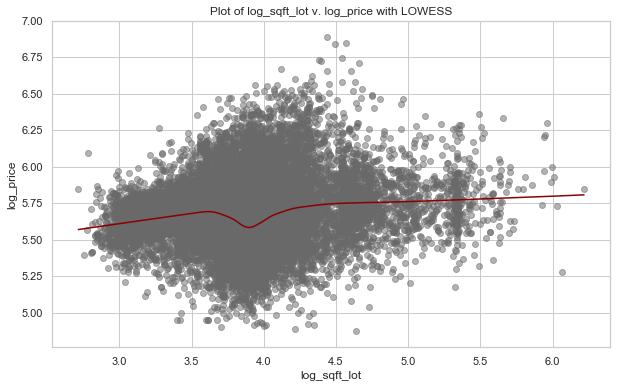

In [88]:
lowess_scatter(data, "log_sqft_lot", "log_price")

The line is very nearly horizontal which is what the $r$ statistic was telling us.

### floors and price

It's difficult to believe that floors alone influence price. Floors would be correlated with lot size (a larger house on a smaller lot requires more floors) and thus floors might be including information that we already have elsewhere.

In [89]:
correlation(data, "floors", "price")

Correlation coefficients:
r   = 0.2567938875507184
rho = 0.32234655003563695


The correlation statistics seem to agree that floors have a very weak relationship with price.

Looking at the descriptive statistics by count of floors, we have:

In [90]:
describe_by_category(data, "price", "floors")

          count       mean       std       min       25%       50%        75%        max
floors                                                                                  
1.00   10680.00  442180.63 264003.24  75000.00 275000.00 390000.00  530000.00 4668000.00
1.50    1910.00  558980.64 303541.33  92000.00 355000.00 524475.00  687875.00 3650000.00
2.00    8241.00  648891.16 433937.66  90000.00 378800.00 542950.00  772500.00 7062500.00
2.50     161.00 1060346.49 858259.49 255000.00 550000.00 799200.00 1300000.00 7700000.00
3.00     613.00  582526.04 338249.17 205000.00 385000.00 490000.00  631500.00 3100000.00
3.50       8.00  933312.50 978616.48 435000.00 513500.00 534500.00  696375.00 3300000.00


which we can chart as a multibloxplot:

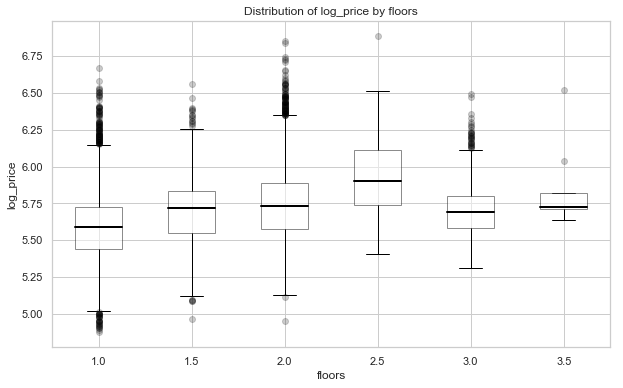

In [91]:
multiboxplot(data, "log_price", "floors")

The imaginary line that connects the median of each boxplot is fairly flat and even goes down at the end.

### waterfront and price

It seems fairly obvious that a waterfront house in Seattle will, other things being equal, sell for more than the same house on the other side of the street.

In [92]:
correlation(data, "waterfront", "price")

Correlation coefficients:
r   = 0.2663694340306021
rho = 0.1150892802866442


The correlation coefficient tells us that the relationship is weak. Let's see the numbers:

In [93]:
describe_by_category(data, "price", "waterfront")

              count       mean        std       min       25%        50%        75%        max
waterfront                                                                                    
0          21450.00  531563.60  341599.59  75000.00 320000.00  450000.00  639897.00 7700000.00
1            163.00 1661876.02 1120371.73 285000.00 760000.00 1400000.00 2215000.00 7062500.00


The mean price of a water front home is substantially higher than a non water front home. But the variation is incredibly large. We can visualize this with a box plot:

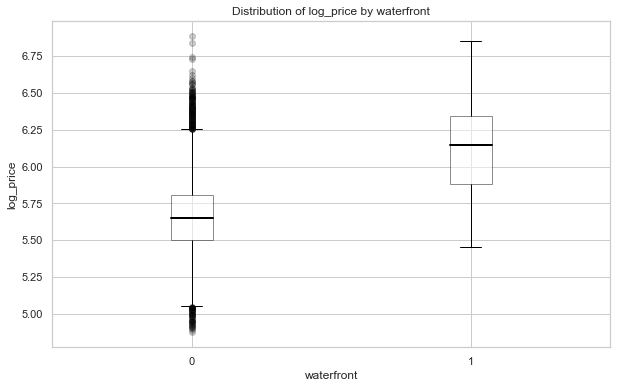

In [94]:
multiboxplot(data, "log_price", "waterfront")

While the waterfront distribution seems very stable (the median is high, there are no "outliers") the variation in the non-waterfront homes is substantial. This may make isolating the waterfront effect difficult.

### view and price

We have the same expectation for view that we did for waterfront. A better view, other things being equal, will probably command a better price. The main problem at this stage is that we're not able to hold things equal.

One experiment we could do would be to subset houses based on common (modal) characteristics and then compare waterfront versus non-waterfront and view versus non-view.

In [95]:
correlation(data, "view", "price")

Correlation coefficients:
r   = 0.3972934882945043
rho = 0.29393116417024306


As expected, the relationship between view and price is not very strong.  Let's look at the descriptive statistics:

In [96]:
describe_by_category(data, "price", "view")

        count       mean       std       min       25%        50%        75%        max
view                                                                                   
0    19489.00  496564.19 287133.30  75000.00 311000.00  432500.00  600000.00 5570000.00
1      332.00  812280.84 510949.68 217000.00 498750.00  690944.00  921250.00 3650000.00
2      963.00  792400.89 510105.05 169317.00 485000.00  675000.00  941250.00 7062500.00
3      510.00  971965.27 612692.24 154000.00 554000.00  802500.00 1256000.00 7700000.00
4      319.00 1463711.24 952209.55 252000.00 817500.00 1185000.00 1850000.00 6885000.00


There is an inversion from view 1 and view 3 (the mean goes up then down then up). We should be able to see this with box plots:

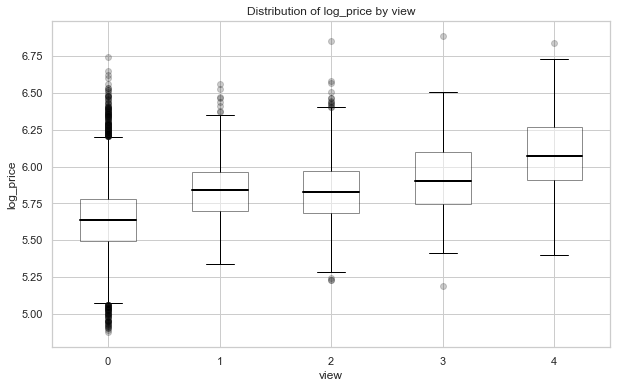

In [97]:
multiboxplot(data, "log_price", "view")

There definitely seems to be an upward trend but it's a bit weak in "the middle". We need to find the data dictionary and learn what the `view` variable actually specifies. Perhaps we may want to recode it to three values (0, 1-3, 4).

### condition and price

Condition and price should definitely go together with better condition houses commanding a higher price.

In [98]:
correlation(data, "condition", "price")

Correlation coefficients:
r   = 0.036361789128997554
rho = 0.018489958301262526


Surprisingly, there's nearly no relationship between condition and price. Possibly, condition doesn't mean what we think it means?  Let's look descriptive statistics.

In [99]:
describe_by_category(data, "price", "condition")

             count      mean       std       min       25%       50%       75%        max
condition                                                                                
1            30.00 334431.67 271172.80  78000.00 160000.00 262500.00 431125.00 1500000.00
2           172.00 327287.15 245418.41  80000.00 189750.00 279000.00 397300.00 2555000.00
3         14031.00 542012.58 364449.06  75000.00 329500.00 450000.00 640000.00 7062500.00
4          5679.00 521200.39 358516.23  89000.00 305000.00 440000.00 625000.00 7700000.00
5          1701.00 612418.09 410971.92 110000.00 350000.00 526000.00 725000.00 3650000.00


The mean does have an upward trend but the variation defies our ability to to make any definitive claims. We may need to hold other things constant in a more detailed analysis.

You'll often see the latin phrases *ceteris paribus* ("other things equal") and *mutatis mutandis* ("necessary changes having been made") in analysis (especially economics). *ceteris paribus* is equivalent to the statement "holding things equal" whereas *mutatis mutandis* requires you to make the obvious changes. It is equivalent to the statement "without loss of generality". When a statement is prefixed by "WLG", it means "I am making specific assumptions but they do not matter for the argument."

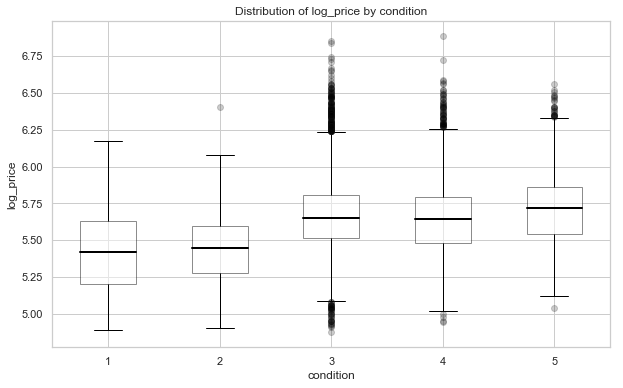

In [100]:
multiboxplot(data, "log_price", "condition")

There appears to be a change between 1-2 and 3-5 but the variation on 3 is still quite high.

### grade and price

We expect grade to have a positive influence on price.

In [101]:
correlation(data, "grade", "price")

Correlation coefficients:
r   = 0.6674342560202371
rho = 0.6582152214259374


With the exception of living area, grade has the strongest correlation with price that we've seen so far. we can generate the descriptive statistics but with so many grades (13 in all), this would be better as a visualization.

In [102]:
describe_by_category(data, "price", "grade")

        count       mean        std        min        25%        50%        75%        max
grade                                                                                     
1        1.00  142000.00        nan  142000.00  142000.00  142000.00  142000.00  142000.00
3        3.00  205666.67  113517.99   75000.00  168500.00  262000.00  271000.00  280000.00
4       29.00  214381.03   94306.17   80000.00  145000.00  205000.00  265000.00  435000.00
5      242.00  248523.97  118100.28   78000.00  175000.00  228700.00  295750.00  795000.00
6     2038.00  301919.64  122970.28   82000.00  215037.50  275276.50  366837.50 1200000.00
7     8981.00  402590.26  155876.92   90000.00  285000.00  375000.00  485000.00 2050000.00
8     6068.00  542852.77  217473.37  140000.00  390000.00  510000.00  640000.00 3070000.00
9     2615.00  773513.19  316120.08  230000.00  571500.00  720000.00  880000.00 2700000.00
10    1134.00 1071771.07  483545.09  316000.00  768087.50  914327.00 1250000.00 3600000.00

Here is the boxplot:

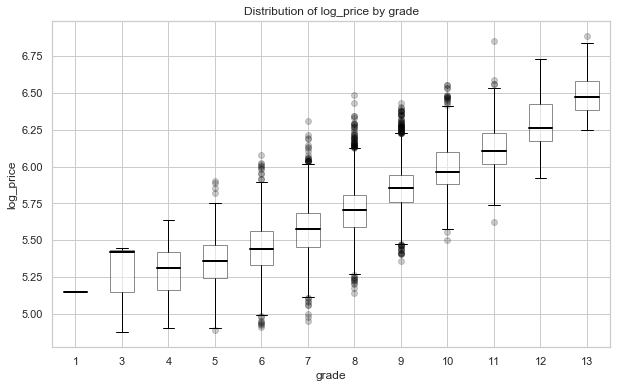

In [103]:
multiboxplot(data, "log_price", "grade")

The upward trend in the (log) price as grade increases is marked. For adjacent grades, there's a lot of overlap but little overlap (at least of the IQR) between grades far from each other. For example, 10 and 11 overlap to a large extent but 11's IQR and 9's IQR don't overlap at all. On the other end, the entire range of 9 and 11 *do* overlap which is why the correlation is not perfect.

### sqft_above and price

Many of the "square foot" variables are probably redundant with each other. It seems unlikely that they capture independent effects (for example, that people prefer most their living spaces to not be in the basement) and if there are independent effects, we may not have sufficient data to estimate them. For example, because so few houses have waterfront or basements.

In [104]:
correlation(data, "sqft_above", "price")

Correlation coefficients:
r   = 0.6055672983560783
rho = 0.5417515924329482


In [105]:
correlation(data, "log_sqft_above", "price")

Correlation coefficients:
r   = 0.5427336329498287
rho = 0.5417515924329482


The correlation between above ground (above basement) living area and price is borderline. Below we can see a scatter plot for the data:

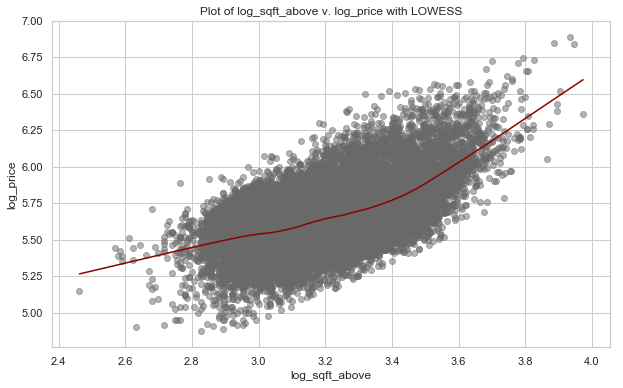

In [106]:
lowess_scatter(data, "log_sqft_above", "log_price")

Here we're charting log price against log square footage not in the basement. As we have mentioned before, in log-log space, non-linear relationships are linear. The curve above as a bit of a bend which is interesting because the same kind of bend occurred in the total square footage of living space.

### sqft_basement and price

Unlike the other "square foot" measurements, it seems doubtful that *basement* size alone has an effect on prices. Of course, it might be negative. What if a house has 2 more bedrooms and 1 more bathroom because they're in the basement?

In [107]:
correlation(data, "sqft_basement", "price")

Correlation coefficients:
r   = 0.32381602071198395
rho = 0.251704401174526


The relationship is slightly positive and weak. The scatterplot is below:

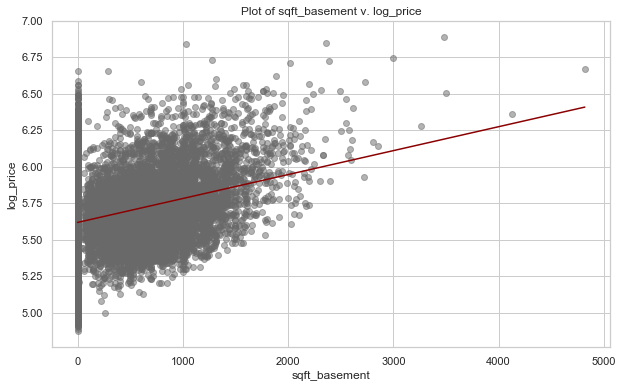

In [108]:
lowess_scatter(data, "sqft_basement", "log_price", jitter=0.0, skip_lowess=True)

Here we see a very large number of houses without basements. It might be worthwhile to look at the data just for houses with basements and see if the relationship is stronger:

In [109]:
with_basement = data[data["sqft_basement"] > 0]

In [110]:
correlation(with_basement, "sqft_basement", "price")

Correlation coefficients:
r   = 0.4073082433779587
rho = 0.3383598506716071


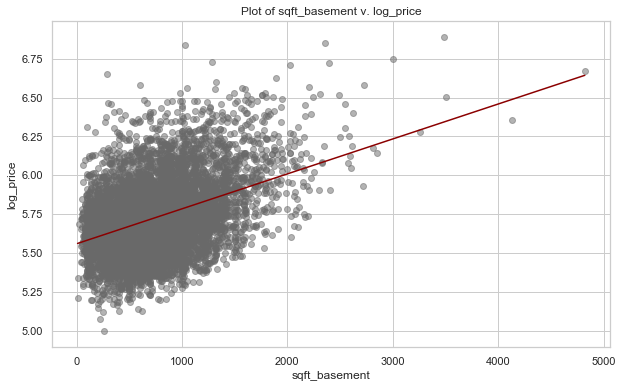

In [111]:
lowess_scatter(with_basement, "sqft_basement", "log_price", jitter=0.0, skip_lowess=True)

So it seems that, for houses with basements, the size of the basement weakly increases the price.

### yr_built and price

Are older homes cheaper or more expensive?

In [112]:
correlation(data, "yr_built", "price")

Correlation coefficients:
r   = 0.054011531494792715
rho = 0.10203756645939753


There is almost no correlation between the year a house was built and the price. We can produce the descriptive statistics:

In [113]:
describe_by_category(data, "price", "yr_built")

          count      mean       std       min       25%       50%        75%        max
yr_built                                                                               
1900      87.00 581387.21 294365.11 130000.00 420000.00 549000.00  715250.00 1695000.00
1901      29.00 556935.93 194756.19 285000.00 410000.00 550000.00  625000.00 1225000.00
1902      27.00 673007.41 363707.54 260000.00 446475.00 624000.00  766125.00 1990000.00
1903      46.00 480958.20 203860.97 167500.00 330000.00 461000.00  576758.75 1020000.00
1904      45.00 583756.64 464006.90 204995.00 350000.00 478000.00  687500.00 3300000.00
1905      74.00 752977.99 464207.82  90000.00 438750.00 597500.00  946250.00 2250000.00
1906      92.00 669799.40 412628.28 165000.00 438712.50 555000.00  776750.00 2725000.00
1907      65.00 676257.25 407129.71 202000.00 455000.00 595000.00  762000.00 2400000.00
1908      86.00 564348.69 360565.98 111300.00 368500.00 519475.00  653750.00 2538000.00
1909      94.00 696135.16 457242

and a quick scan doesn't reveal anything but a chart would be better:

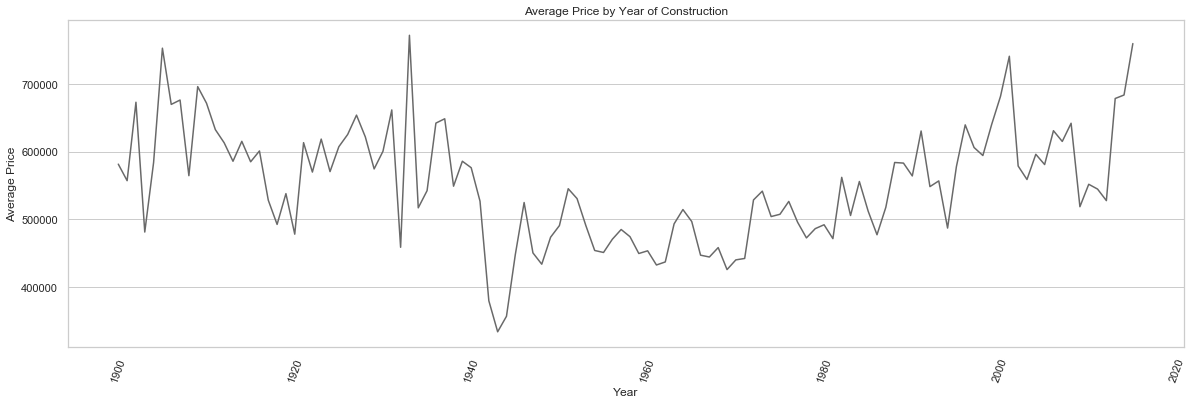

In [114]:
grouped = data.groupby("yr_built")
grouped_y = pd.DataFrame(grouped["price"].describe())

figure = plt.figure(figsize=(20, 6))

axes = figure.add_subplot(1, 1, 1)
axes.plot(grouped_y.index, grouped_y["mean"], color="dimgray")
axes.set_title( "Average Price by Year of Construction")
axes.set_xlabel("Year")
axes.set_ylabel( "Average Price")
axes.xaxis.grid(False)
plt.setp( axes.xaxis.get_majorticklabels(), rotation=70)

plt.show()
plt.close()

This is unexpected. There appears to be higher prices for very old homes (built before WW2) and for new homes (late 1990s and newer). Perhaps these types of homes appeal to different kinds of buyers. The first for old homes near city centers and the second for brand new homes. The homes in the middle are run-of-the-mill tract homes in the suburbs.

### yr_renovated and price

As we notice before, very few homes have actually been renovated. It's difficult to believe that yr_renovated has an effect on price or, if it does, we can use it.

In [115]:
correlation(data, "yr_renovated", "price")

Correlation coefficients:
r   = 0.12643379344089295
rho = 0.10187550718175704


As expected, there's very little correlation.

In [116]:
describe_by_category(data, "price", "yr_renovated")

                count       mean        std       min       25%        50%        75%        max
yr_renovated                                                                                    
0            20699.00  530360.82  349578.01  75000.00 320000.00  448000.00  634400.00 6885000.00
1934             1.00  459950.00        nan 459950.00 459950.00  459950.00  459950.00  459950.00
1940             2.00  378400.00   92065.30 313300.00 345850.00  378400.00  410950.00  443500.00
1944             1.00  521000.00        nan 521000.00 521000.00  521000.00  521000.00  521000.00
1945             3.00  398666.67  155853.56 256000.00 315500.00  375000.00  470000.00  565000.00
1946             2.00  351137.50  281234.04 152275.00 251706.25  351137.50  450568.75  550000.00
1948             1.00  410000.00        nan 410000.00 410000.00  410000.00  410000.00  410000.00
1950             2.00  291450.00  195939.29 152900.00 222175.00  291450.00  360725.00  430000.00
1951             1.00  276000.

### zipcode and price

We have an idea that "better" zipcodes will have higher priced homes. Of course, some of that is circular. If a neighborhood is better than another, there will be higher demand for its houses, increasing prices. But as prices increase, there is often more property tax available which makes schools and other amenities better. There is often a "good school tax" associated with homes in areas with good school districts whereby their price exceeds what you would normally expect. It would be interesting to get data on schools and school districts to correlate with prices.

Because of the large number of zipcodes, tables will be difficult to scan but the same will be true of charts. Let's try a box plot:

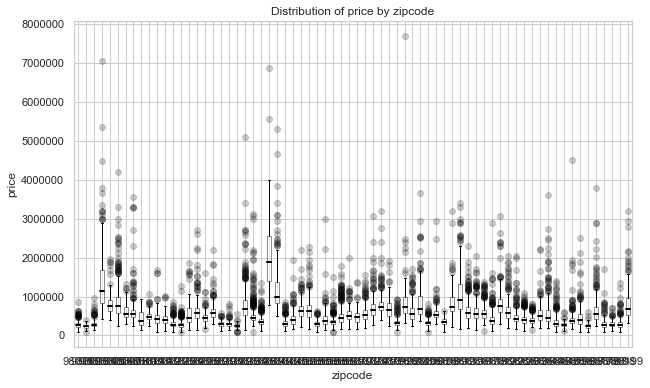

In [117]:
multiboxplot(data, "price", "zipcode")

There's a lot going on here but we can definitely see some patterns. There are a few zipcodes with prices all over the range but there are also a few with low prices and low variation and a few with high prices and low variation. Most have outliers in the "high price" direction.

We should consider redoing this chart with sorted medians. That would require us to bypass the automatic boxplot generation and do a `groupby`. This is probably a good candidate for mapping as well although if we go to that effort, we should probably consider just using latitude and longitude.

Perhaps a better idea would be to use zip code as "foreign key" into other data and enrich the current data set with income, school, and commercial information.

### sqft_living15 and price

It's unlikely that the 2015 square footage of living space can tell us anything new:

In [118]:
correlation(data, "sqft_living15", "price")

Correlation coefficients:
r   = 0.585378903579568
rho = 0.5722897679433038


If we compare it to the original value:

In [119]:
correlation(data, "sqft_living", "price")

Correlation coefficients:
r   = 0.7020350546118
rho = 0.6441909821578404


We can see that the correlation actually goes down. At least for now, there's no reason to look at this variable directly. However, we may be able to use it to *derive* an interesting variable such as added square feet.

### sqft_lot15 and price

Similarly, we have few hopes for the new lot size. It doesn't seem like something that would happen very often.

In [120]:
correlation(data, "sqft_lot15", "price")

Correlation coefficients:
r   = 0.08244715251948598
rho = 0.06276581932483256


And, as with `sqft_lot` before, the correlation is low.

## Summary

Doing a comprehensive EDA is an involved task that takes a great deal of time and effort. It's also iterative. You can do quick tables and charts for each variable and then go back and do more for each variable. Let the workbook sit for a day before going back so that the analysis appears fresh to you.

Some of the analysis above presupposed some knowledge of modeling, especially linear regression. We haven't gotten to that yet (soon). You'll find that your EDA changes as you know more about what you can do with the data and what you're going to do with the data.

The workbook has gotten quite large (120 code cells). In order to keep the notebook snappy, you may need to break in the workbook into chunks.

Consider using hypertext links in your Jupyter notebook to make navigation easier. Create a table of contents with links to the divisions. Create back links to the Table of Contents.